In [22]:
from data_retriever import DataRetriever
from pre_processing import PreProcessing
from scalers.min_max import MinMax
from regressors.lstm_regressor import LSTMRegressor
from regressors.esn_regressor import ESNRegressor
from decomposers.wavelet_transform import WaveletDecomposition
from decomposers.hilbert_huang     import EMDDecomposition
from chm.chm import CascadeHierarquicalModel
import config
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from regressors.ann_regressor import ANNRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from IPython.display import display, Markdown
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Retrieving data from yahoo API
a = DataRetriever()
a.get_yahoo_stock_data()

#Obtaining yahoo dataset
dataset = a.get_stock_ds()

#Preprocessing yahoo data
pp = PreProcessing(dataset, MinMax)
ds = pp.pre_process_once()

#Setting up column to be used as features
x_cols = ds.columns.difference(['Date'])


[*********************100%***********************]  24 of 24 completed


c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\src\pre_processing.py:301: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds_copy[i + '_RSI'] = rsi
c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\nova-virtual\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


_______________________________________________________________


# ITUB3.SA

### 2010-2013T-2014V

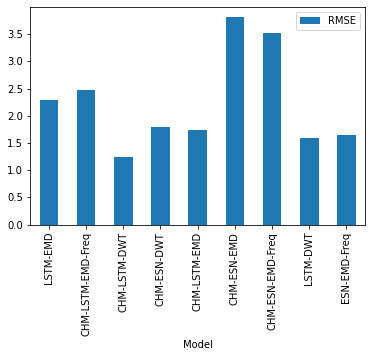

Model      RMSE
2       CHM-LSTM-DWT  1.244206
7           LSTM-DWT  1.585578
8       ESN-EMD-Freq  1.654123
4       CHM-LSTM-EMD  1.744202
3        CHM-ESN-DWT  1.791034
0           LSTM-EMD  2.284399
1  CHM-LSTM-EMD-Freq  2.467604
6   CHM-ESN-EMD-Freq  3.517947
5        CHM-ESN-EMD  3.805608

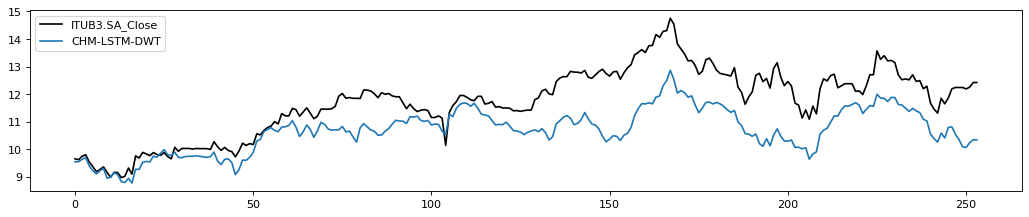

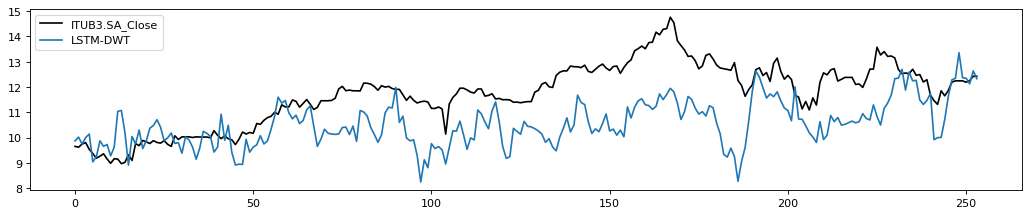

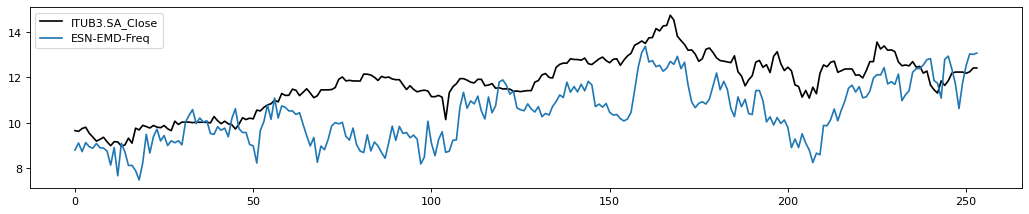

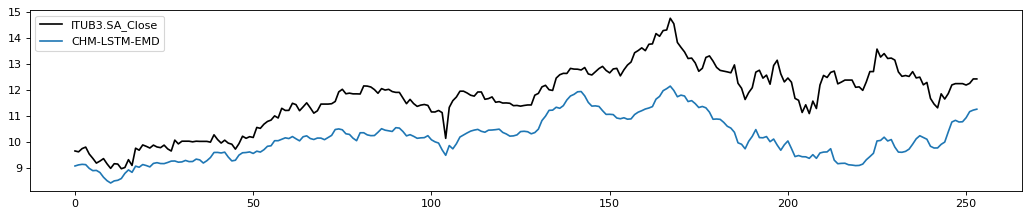

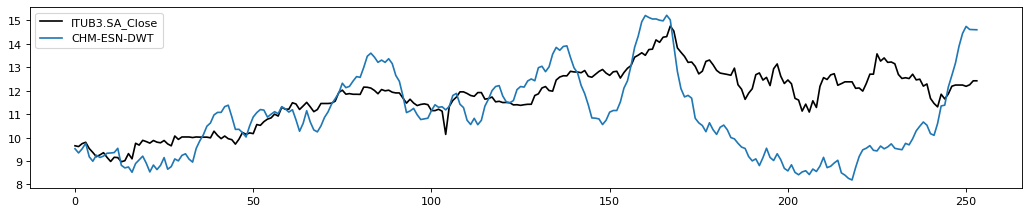

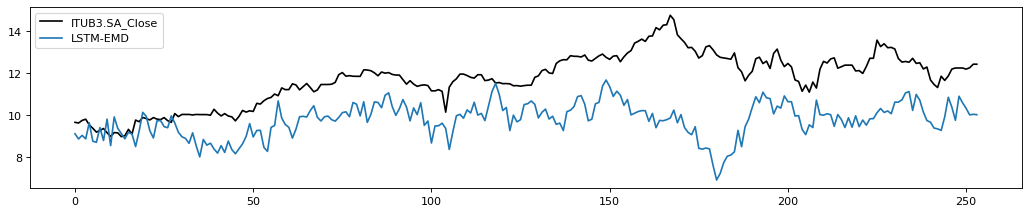

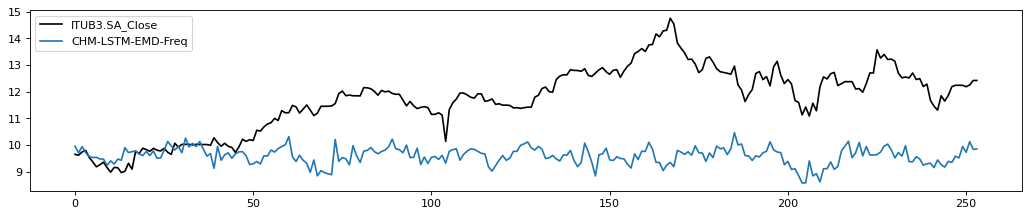

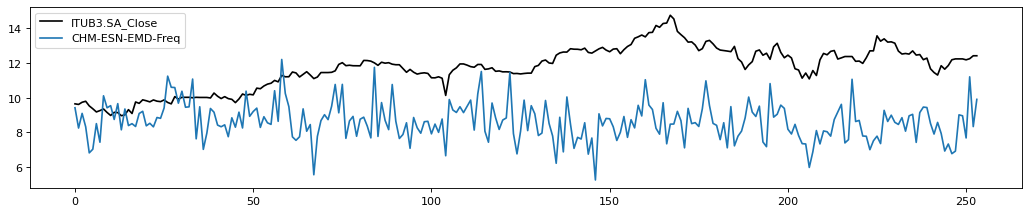

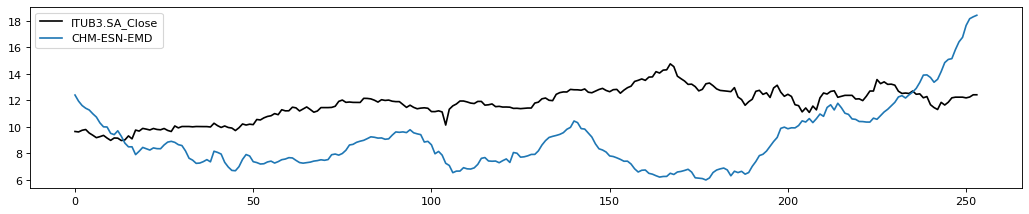

_______________________________________________________________


# ABEV3.SA

### 2010-2013T-2014V

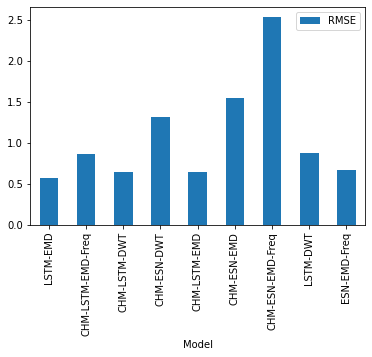

Model      RMSE
0           LSTM-EMD  0.570102
2       CHM-LSTM-DWT  0.635468
4       CHM-LSTM-EMD  0.638719
8       ESN-EMD-Freq  0.671345
1  CHM-LSTM-EMD-Freq  0.857368
7           LSTM-DWT  0.871265
3        CHM-ESN-DWT  1.317684
5        CHM-ESN-EMD  1.538772
6   CHM-ESN-EMD-Freq  2.525669

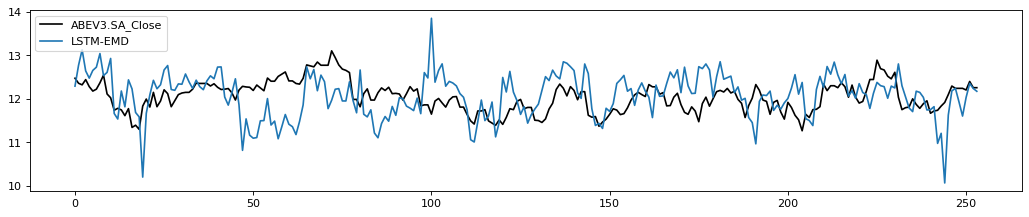

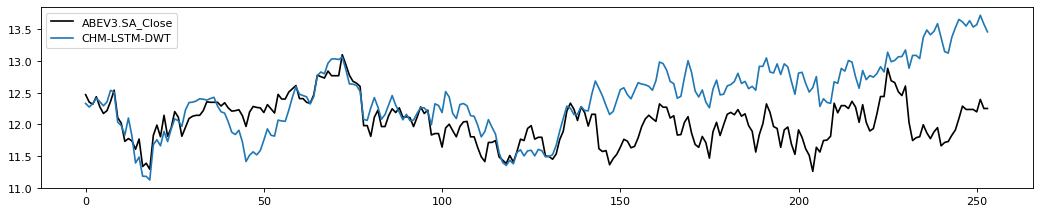

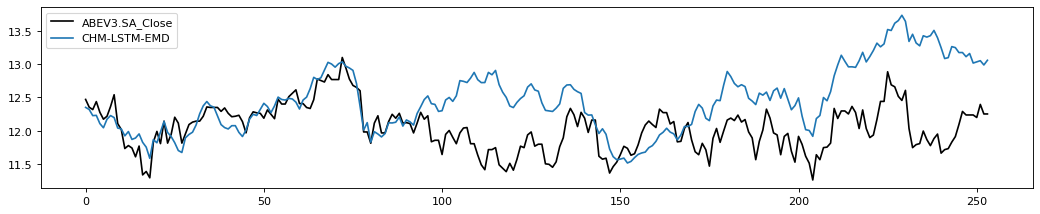

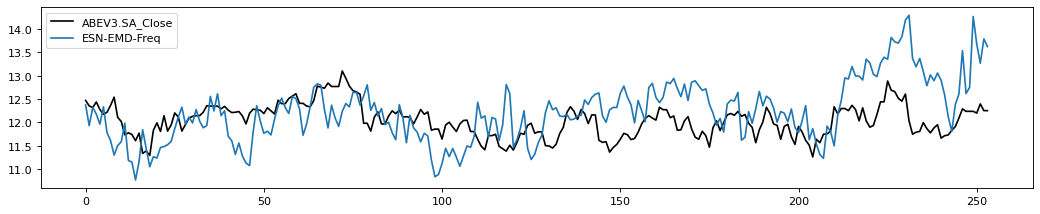

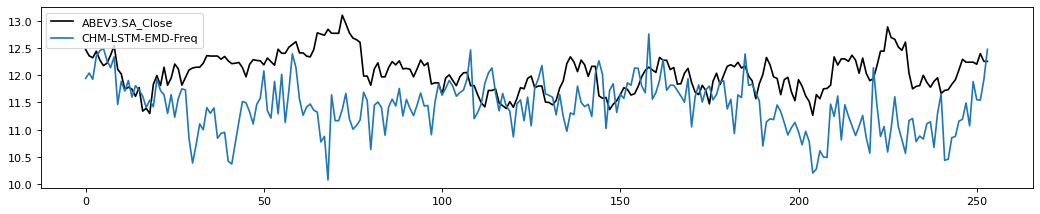

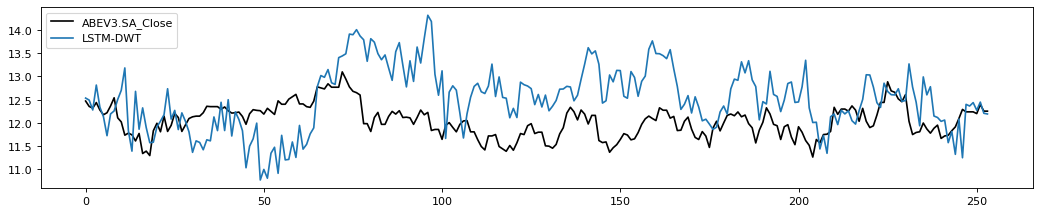

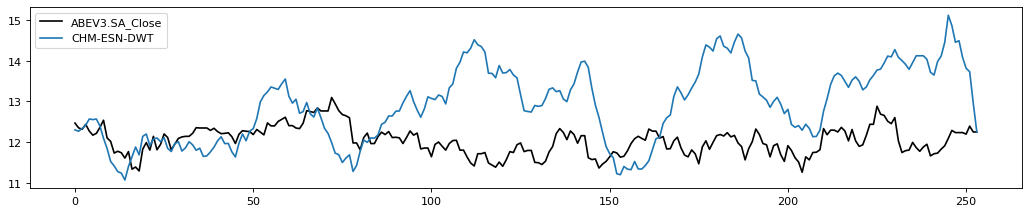

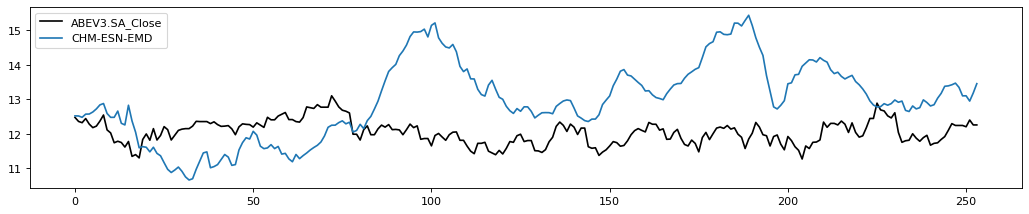

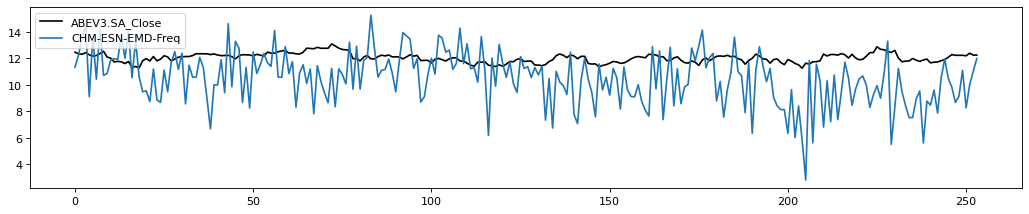

_______________________________________________________________


# B3SA3.SA

### 2010-2013T-2014V

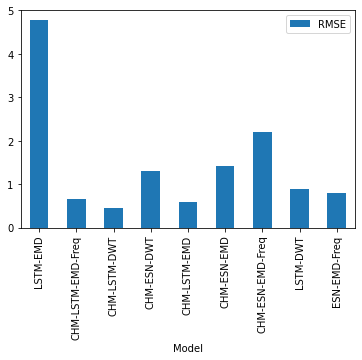

Model      RMSE
2       CHM-LSTM-DWT  0.442424
4       CHM-LSTM-EMD  0.584941
1  CHM-LSTM-EMD-Freq  0.650010
8       ESN-EMD-Freq  0.793728
7           LSTM-DWT  0.885081
3        CHM-ESN-DWT  1.311044
5        CHM-ESN-EMD  1.417650
6   CHM-ESN-EMD-Freq  2.205601
0           LSTM-EMD  4.765758

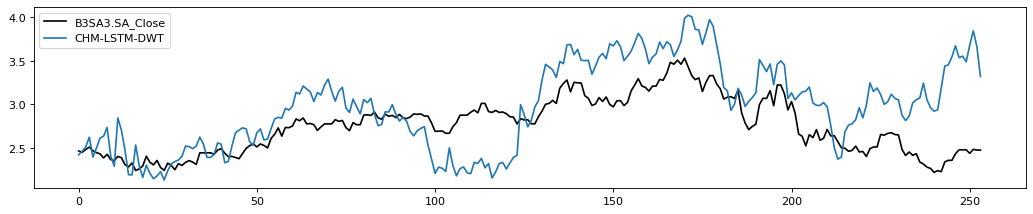

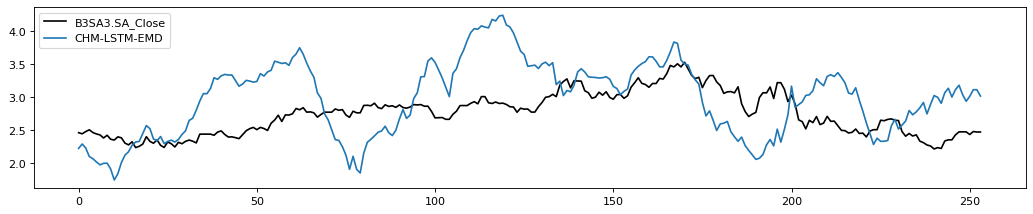

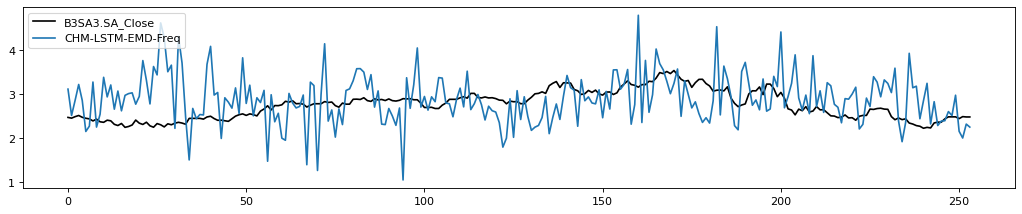

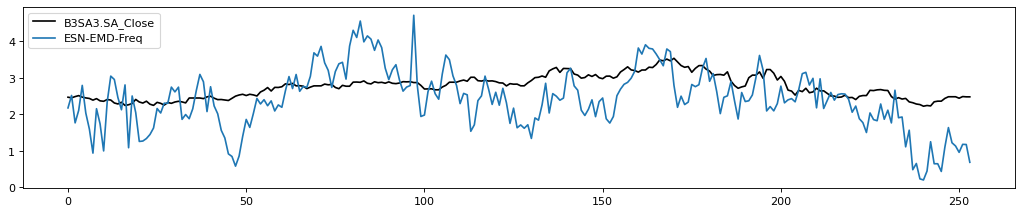

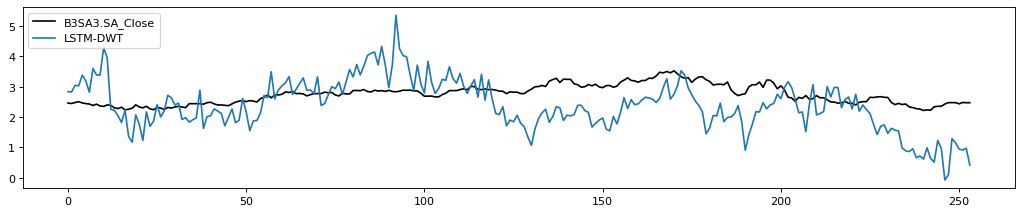

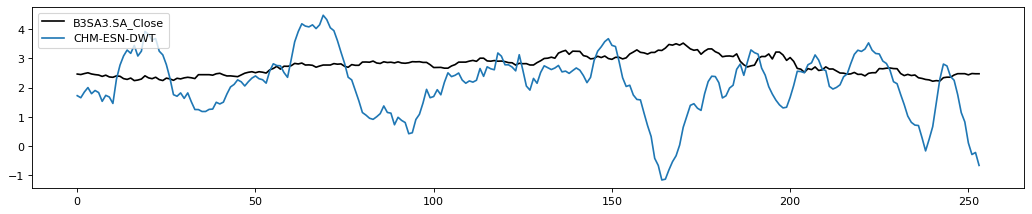

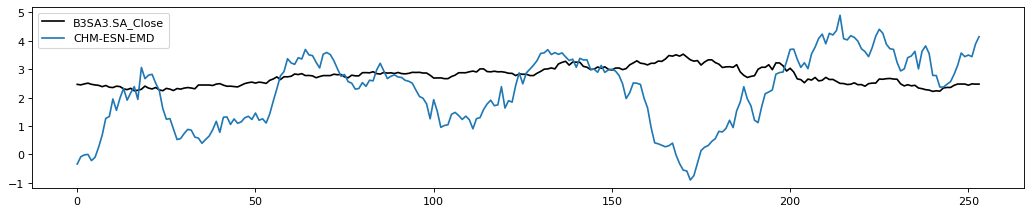

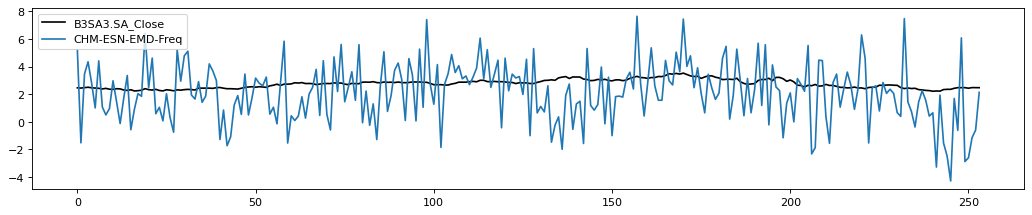

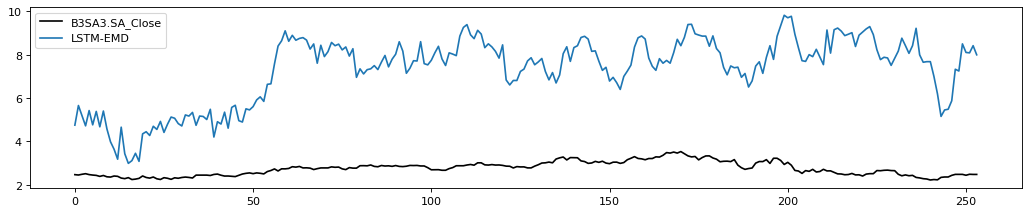

In [27]:
num_models = len(config.Config.model_variations.keys())
kfolds_dict = config.Config.k_fold_variations
until = 99999999
res = dict()
for pred_ticker in config.Config.ticker_stock_market_map['B3']: 
    print('_______________________________________________________________')
    display(Markdown('# ' + pred_ticker))
    
    #Setting up column to be predicted
    y_cols = pred_ticker  + '_Close'

    for kfold in kfolds_dict.keys():
        display(Markdown('### ' + kfold))
        test = ds[ds.apply(lambda x: (x['Date'].year == kfolds_dict[kfold]['validation_year']), axis=1)]

        ground_truth = pp._scalers[y_cols].inverse_transform(test[7:][y_cols].values.reshape(-1,1))
        ground_truth = ground_truth.ravel()
        
        predicted_ds = pd.read_csv('./results_comp/' + kfold + '_' + pred_ticker +'.csv')
        predicted_ds['true'] = ground_truth

        # Plots Table
        metrics = ['RMSE']#['MAPE', 'MSE', 'RMSE']
        df = pd.DataFrame(columns= ['Model'] + metrics)

        for col, i in zip(predicted_ds.columns, range(len(predicted_ds.columns))):
            if col == 'true':
                continue
            
            df.loc[i] =[col, 
                        #mape(predicted_ds['true'][:until], predicted_ds[col][:until]),
                        #mse(predicted_ds['true'][:until], predicted_ds[col][:until]),
                        sqrt(mse(predicted_ds['true'][:until], predicted_ds[col][:until]))
                        ]

        for i in metrics:
            ax = df.plot.bar(x='Model', y=i, rot=0)
            plt.xticks(rotation=90)
            plt.show()

            display(df[['Model', i]].sort_values(by=i))

        # Plots time series
        models = df.sort_values(by='RMSE').reset_index(drop=True)['Model'].values

        for i in models:
            plt.figure(figsize=(16, 3), dpi=80)
            plt.plot(predicted_ds['true'][:until], label= y_cols, color='black')
            plt.plot(predicted_ds[i][:until], label=i)
            plt.legend(loc='upper left')
            plt.show()

In [15]:
file = './results_comp/2010-2013T-2014V_ITUB3.SA.csv'

In [33]:
#until = len(ground_truth)


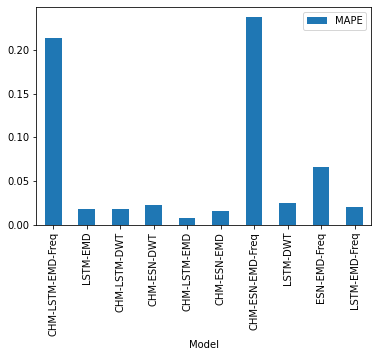

Model      MAPE
4       CHM-LSTM-EMD  0.007185
5        CHM-ESN-EMD  0.015475
1           LSTM-EMD  0.017931
2       CHM-LSTM-DWT  0.018198
9      LSTM-EMD-Freq  0.019745
3        CHM-ESN-DWT  0.022847
7           LSTM-DWT  0.025262
8       ESN-EMD-Freq  0.066095
0  CHM-LSTM-EMD-Freq  0.214050
6   CHM-ESN-EMD-Freq  0.237601

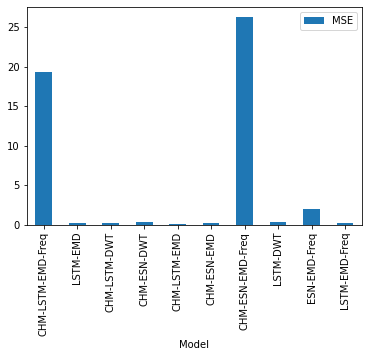

Model        MSE
4       CHM-LSTM-EMD   0.028694
5        CHM-ESN-EMD   0.134674
2       CHM-LSTM-DWT   0.150151
1           LSTM-EMD   0.167679
9      LSTM-EMD-Freq   0.223484
3        CHM-ESN-DWT   0.308867
7           LSTM-DWT   0.352282
8       ESN-EMD-Freq   1.911673
0  CHM-LSTM-EMD-Freq  19.329401
6   CHM-ESN-EMD-Freq  26.229138

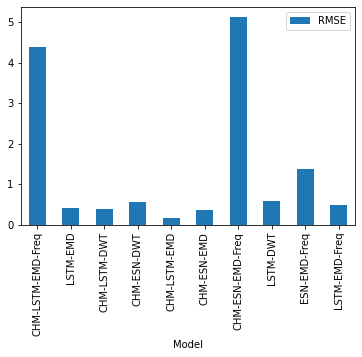

Model      RMSE
4       CHM-LSTM-EMD  0.169393
5        CHM-ESN-EMD  0.366979
2       CHM-LSTM-DWT  0.387494
1           LSTM-EMD  0.409486
9      LSTM-EMD-Freq  0.472741
3        CHM-ESN-DWT  0.555758
7           LSTM-DWT  0.593533
8       ESN-EMD-Freq  1.382633
0  CHM-LSTM-EMD-Freq  4.396521
6   CHM-ESN-EMD-Freq  5.121439

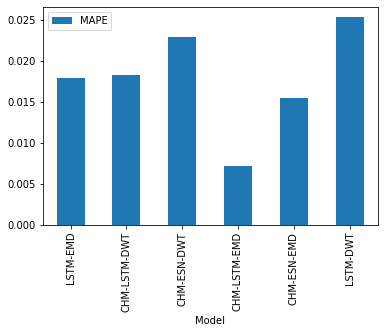

Model      MAPE
4  CHM-LSTM-EMD  0.007185
5   CHM-ESN-EMD  0.015475
1      LSTM-EMD  0.017931
2  CHM-LSTM-DWT  0.018198
3   CHM-ESN-DWT  0.022847
7      LSTM-DWT  0.025262

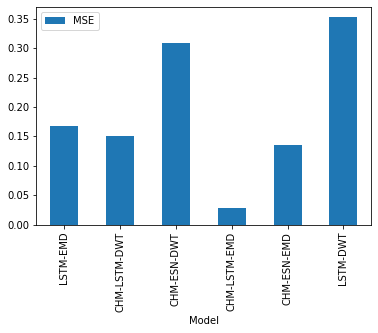

Model       MSE
4  CHM-LSTM-EMD  0.028694
5   CHM-ESN-EMD  0.134674
2  CHM-LSTM-DWT  0.150151
1      LSTM-EMD  0.167679
3   CHM-ESN-DWT  0.308867
7      LSTM-DWT  0.352282

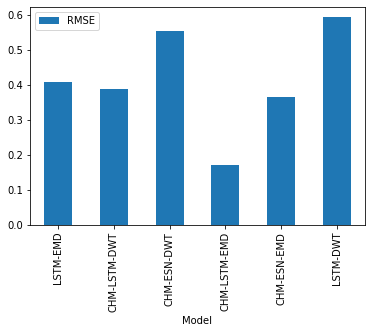

Model      RMSE
4  CHM-LSTM-EMD  0.169393
5   CHM-ESN-EMD  0.366979
2  CHM-LSTM-DWT  0.387494
1      LSTM-EMD  0.409486
3   CHM-ESN-DWT  0.555758
7      LSTM-DWT  0.593533

In [35]:

df = pd.DataFrame(columns= ['Model'] + metrics)

for col, i in zip(predicted_ds.columns, range(len(predicted_ds.columns))):
    if col == 'true' or col[-4:] == 'Freq':
        continue
    
    df.loc[i] =[col, 
                mape(predicted_ds['true'][:until], predicted_ds[col][:until]),
                mse(predicted_ds['true'][:until], predicted_ds[col][:until]),
                sqrt(mse(predicted_ds['true'][:until], predicted_ds[col][:until]))
                ]

for i in metrics:
    ax = df.plot.bar(x='Model', y=i, rot=0)
    plt.xticks(rotation=90)
    plt.show()

    display(df[['Model', i]].sort_values(by=i))
    



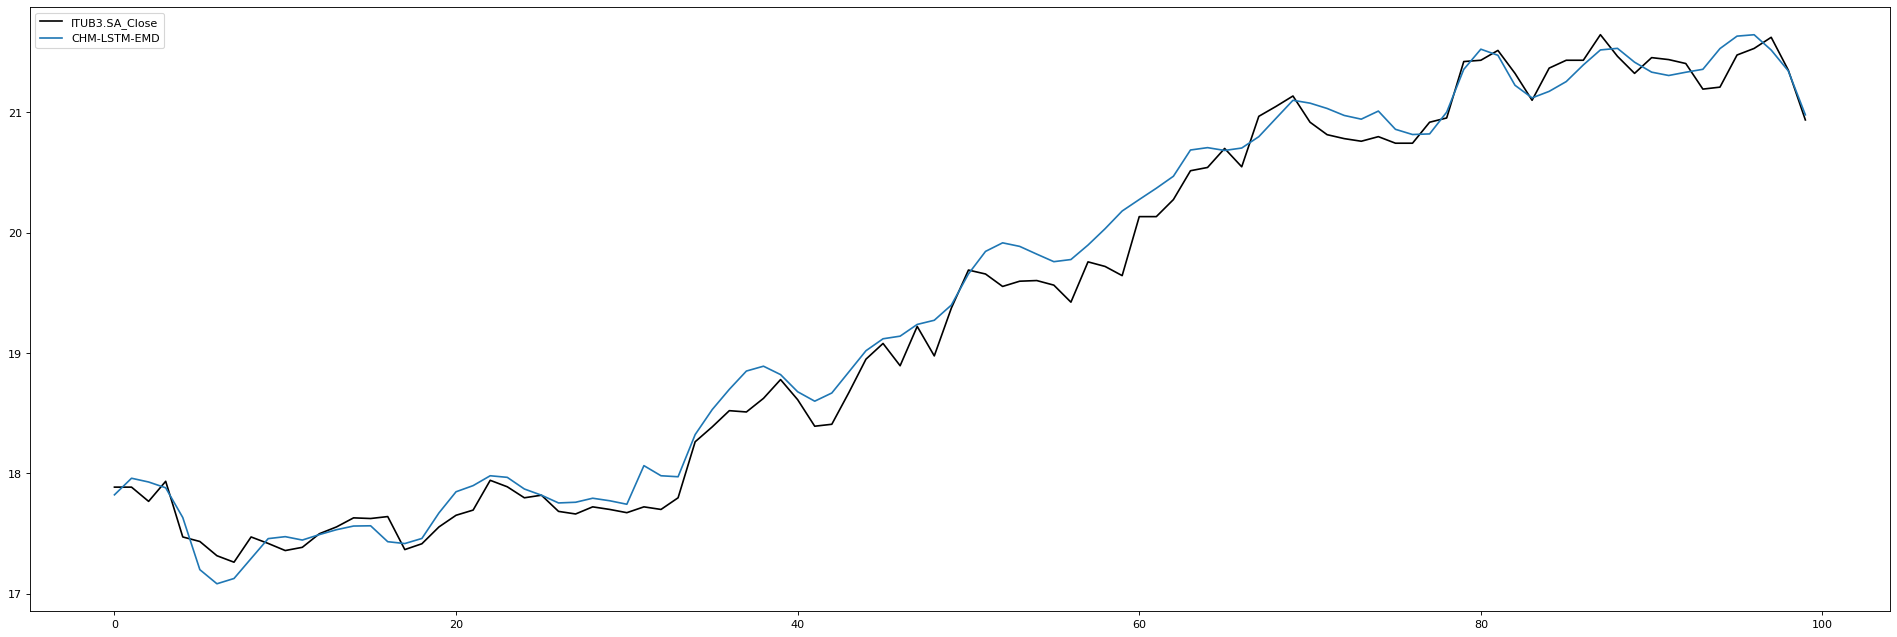

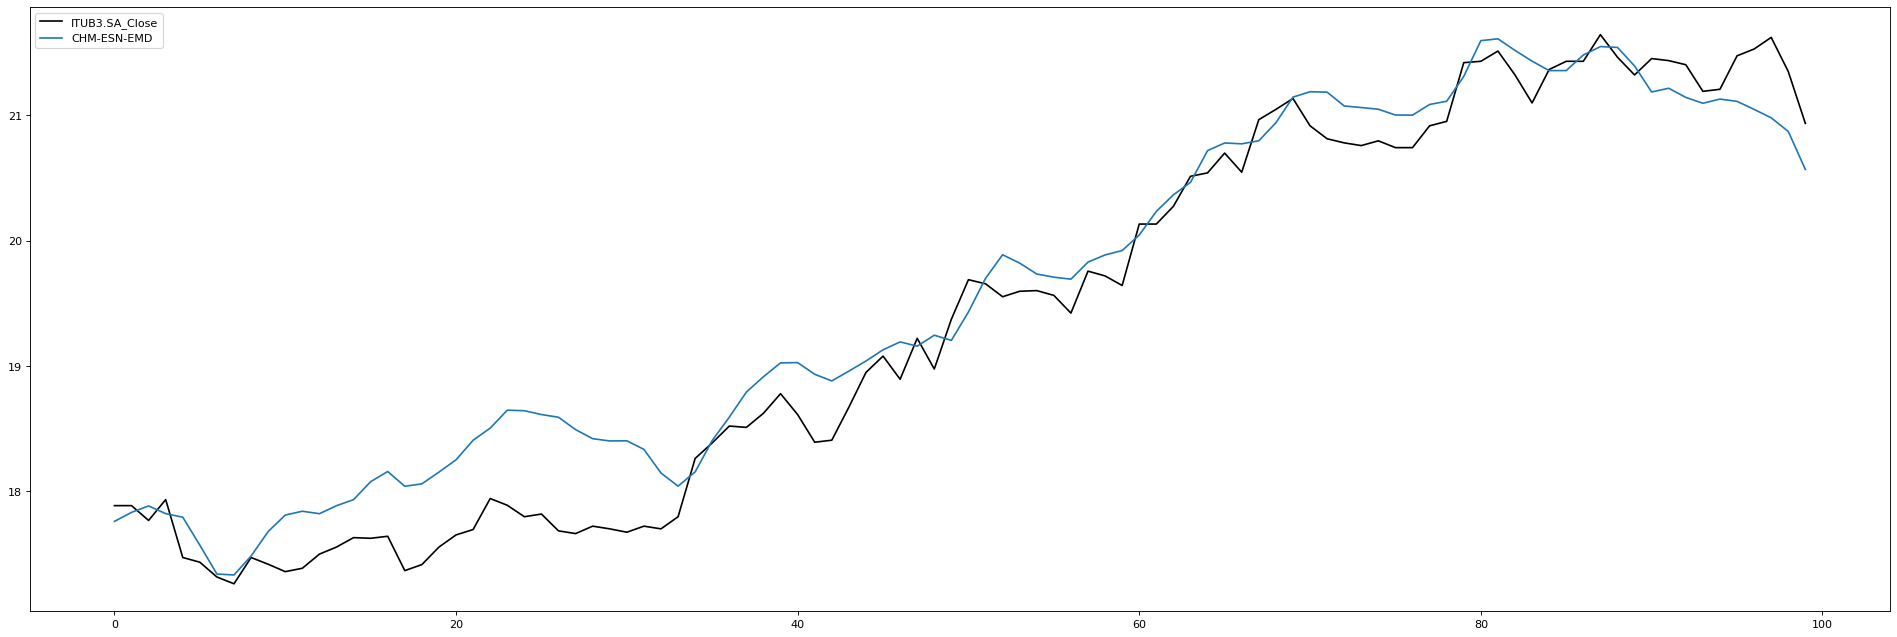

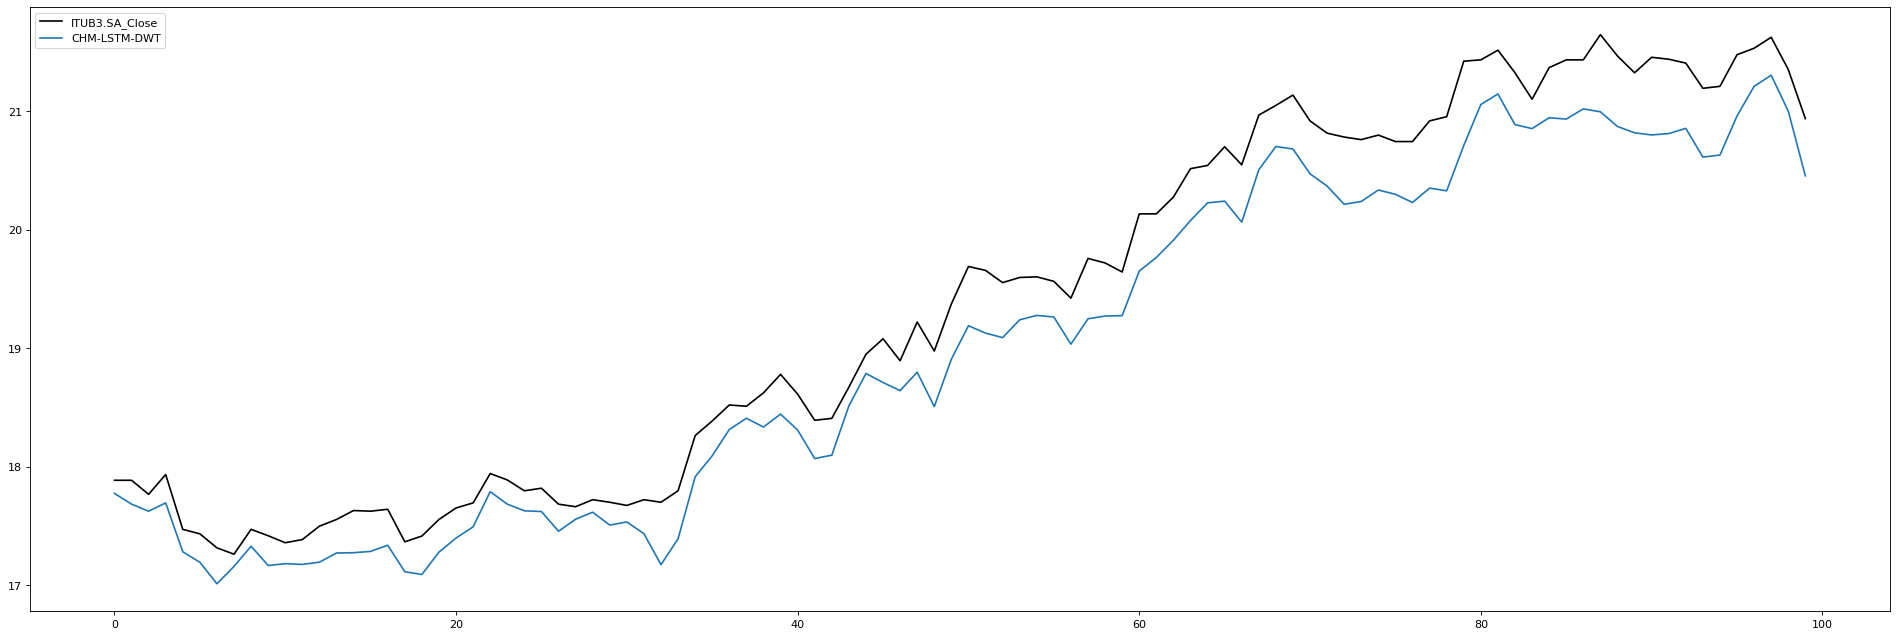

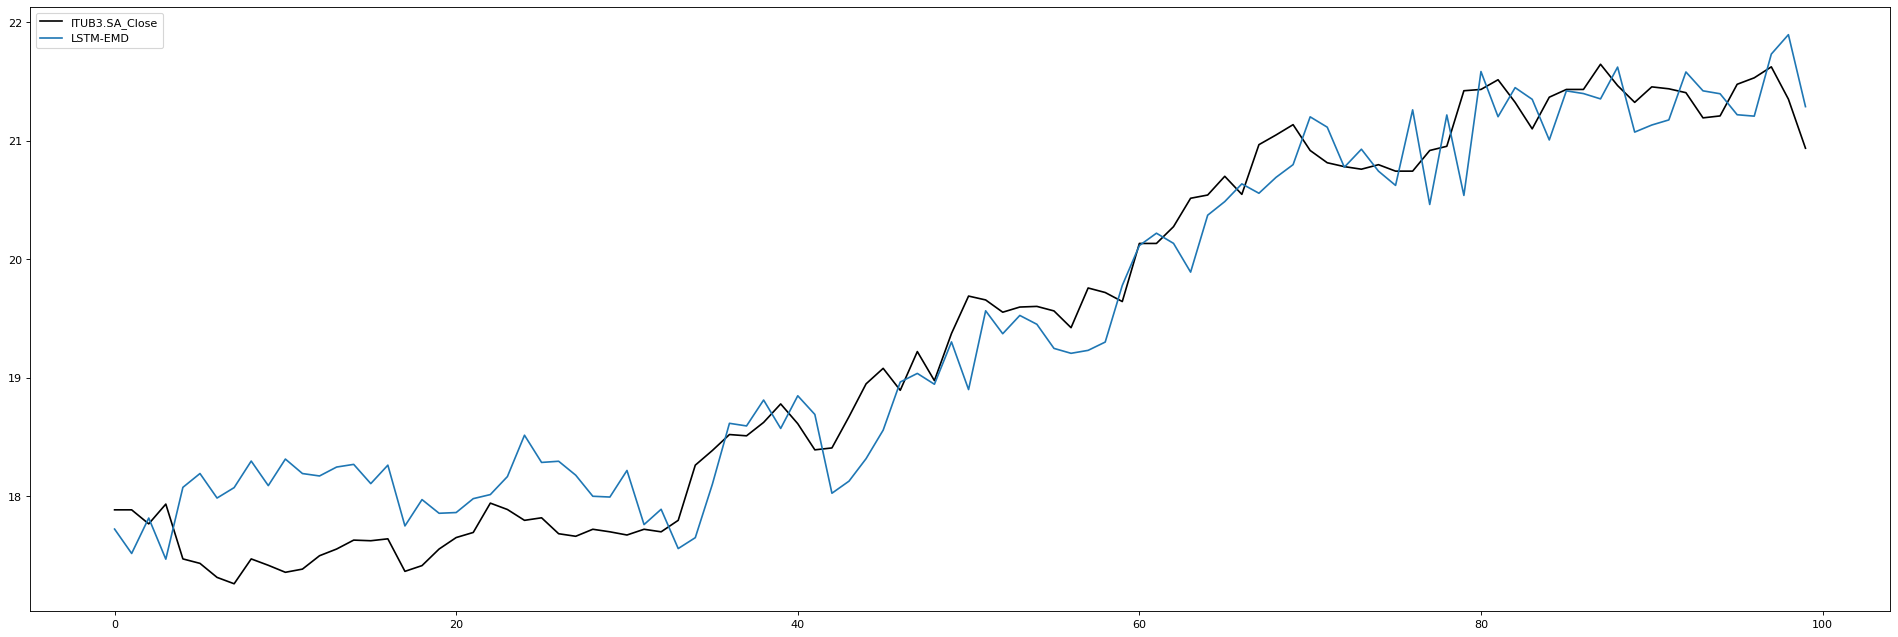

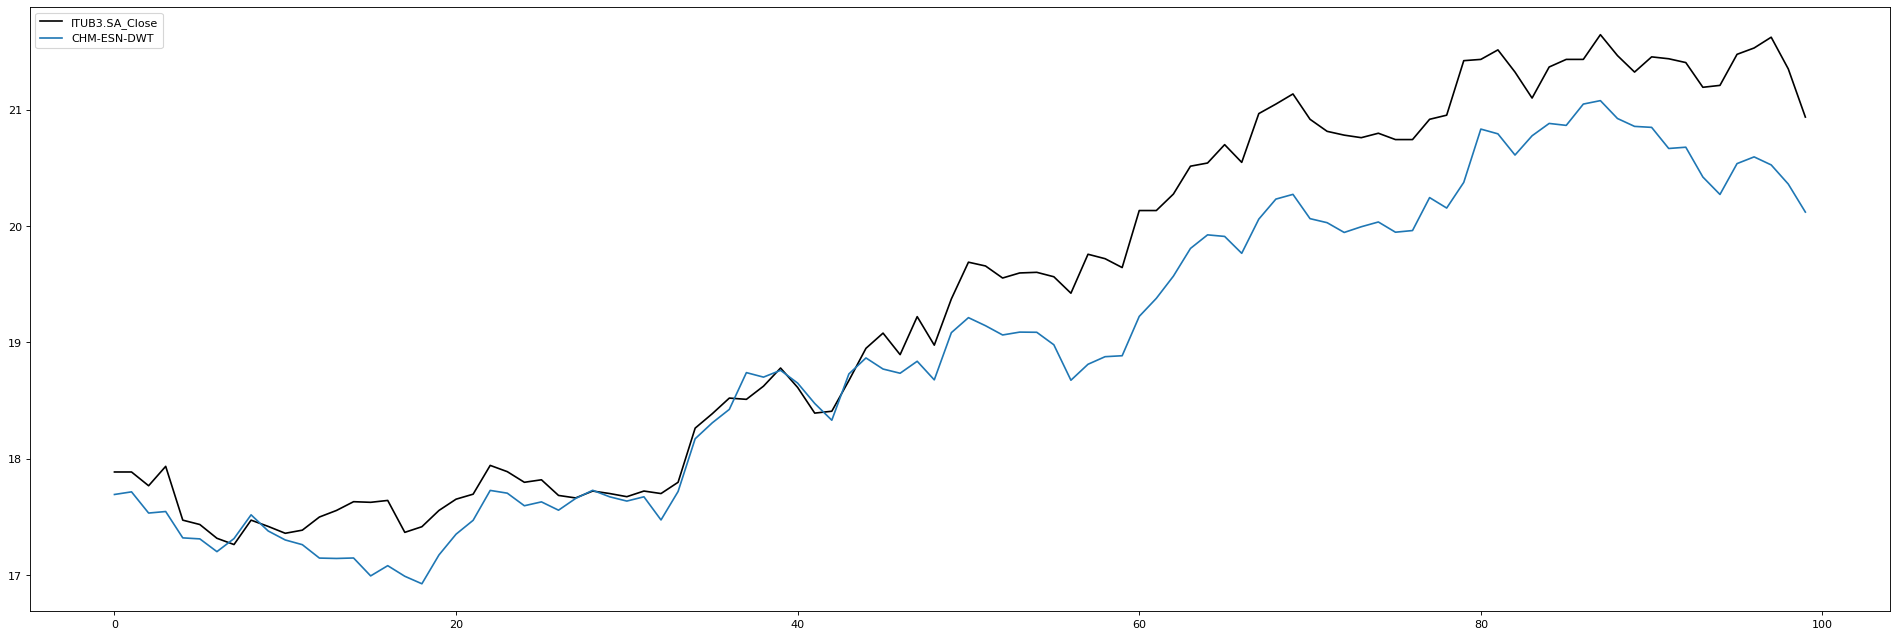

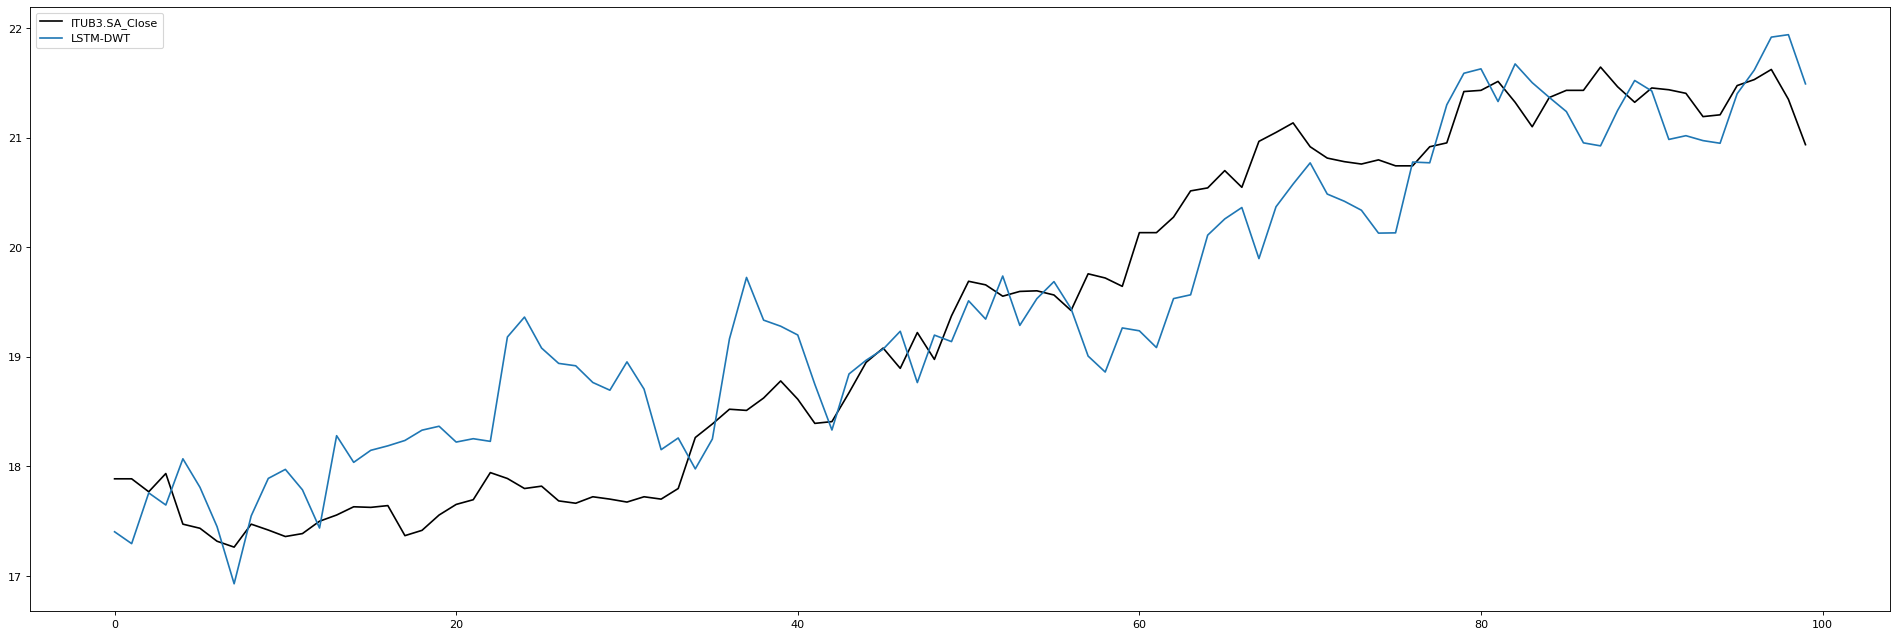

CHM-LSTM-EMD-Freq


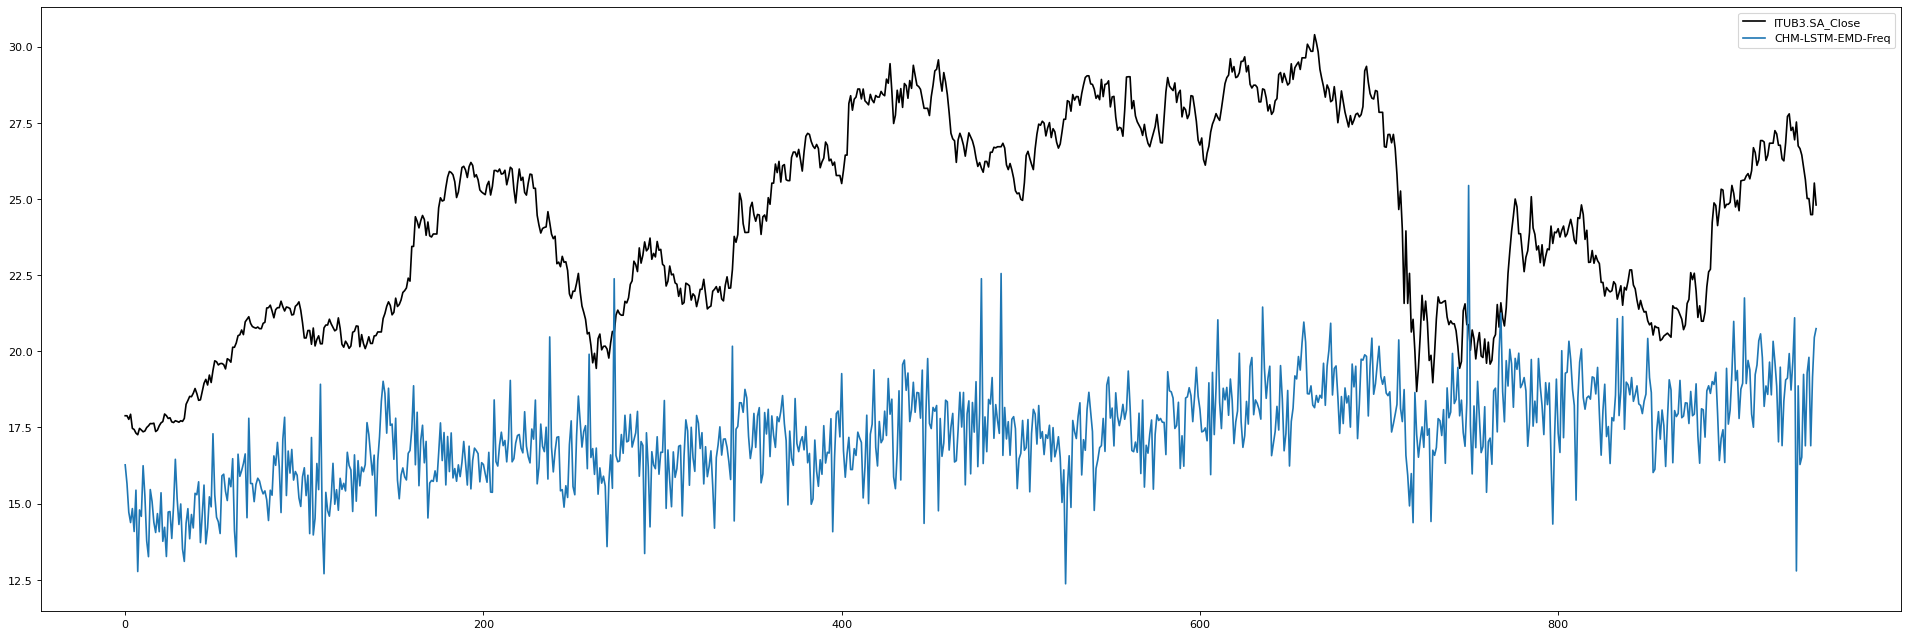

LSTM-EMD


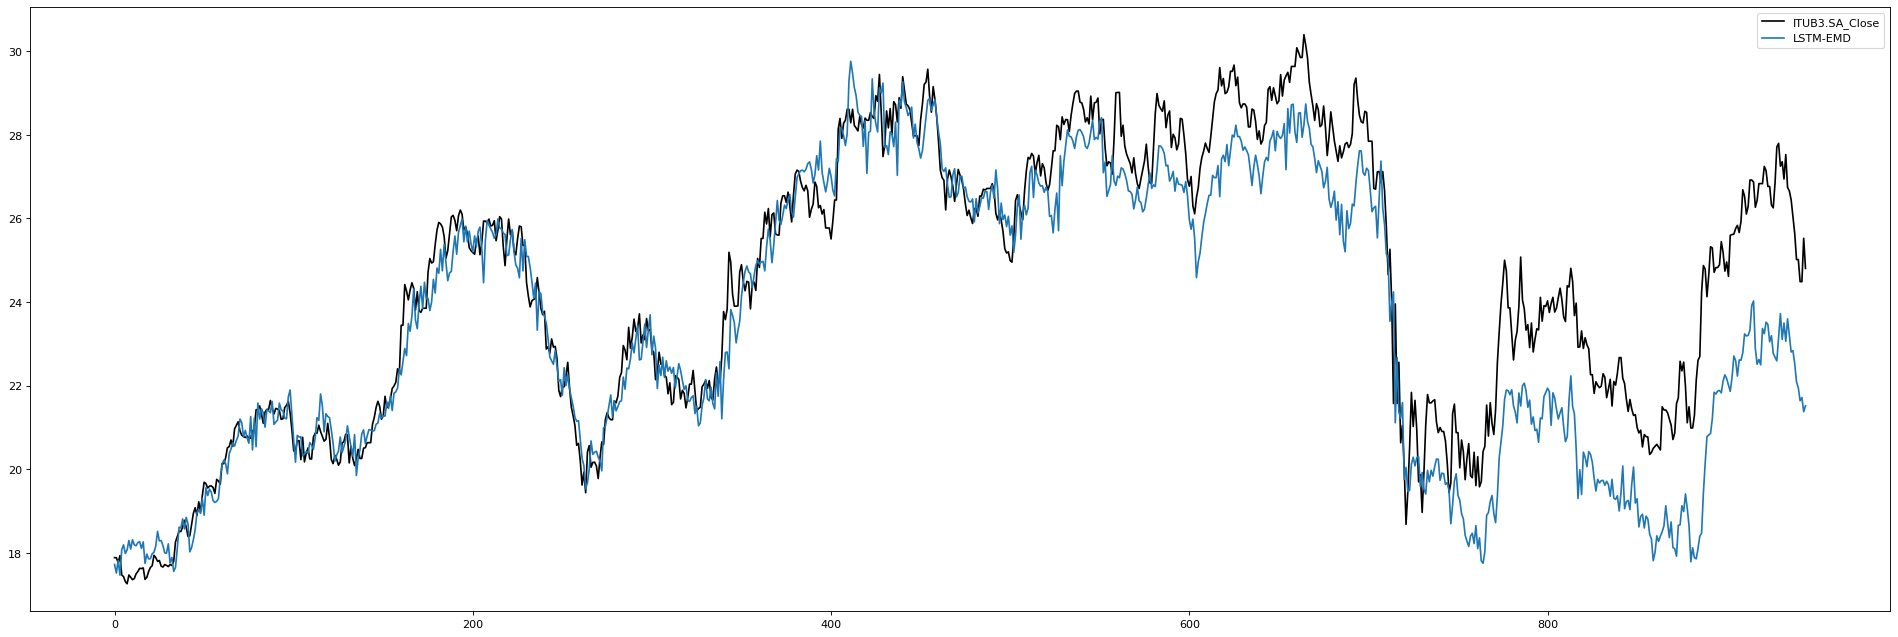

CHM-LSTM-DWT


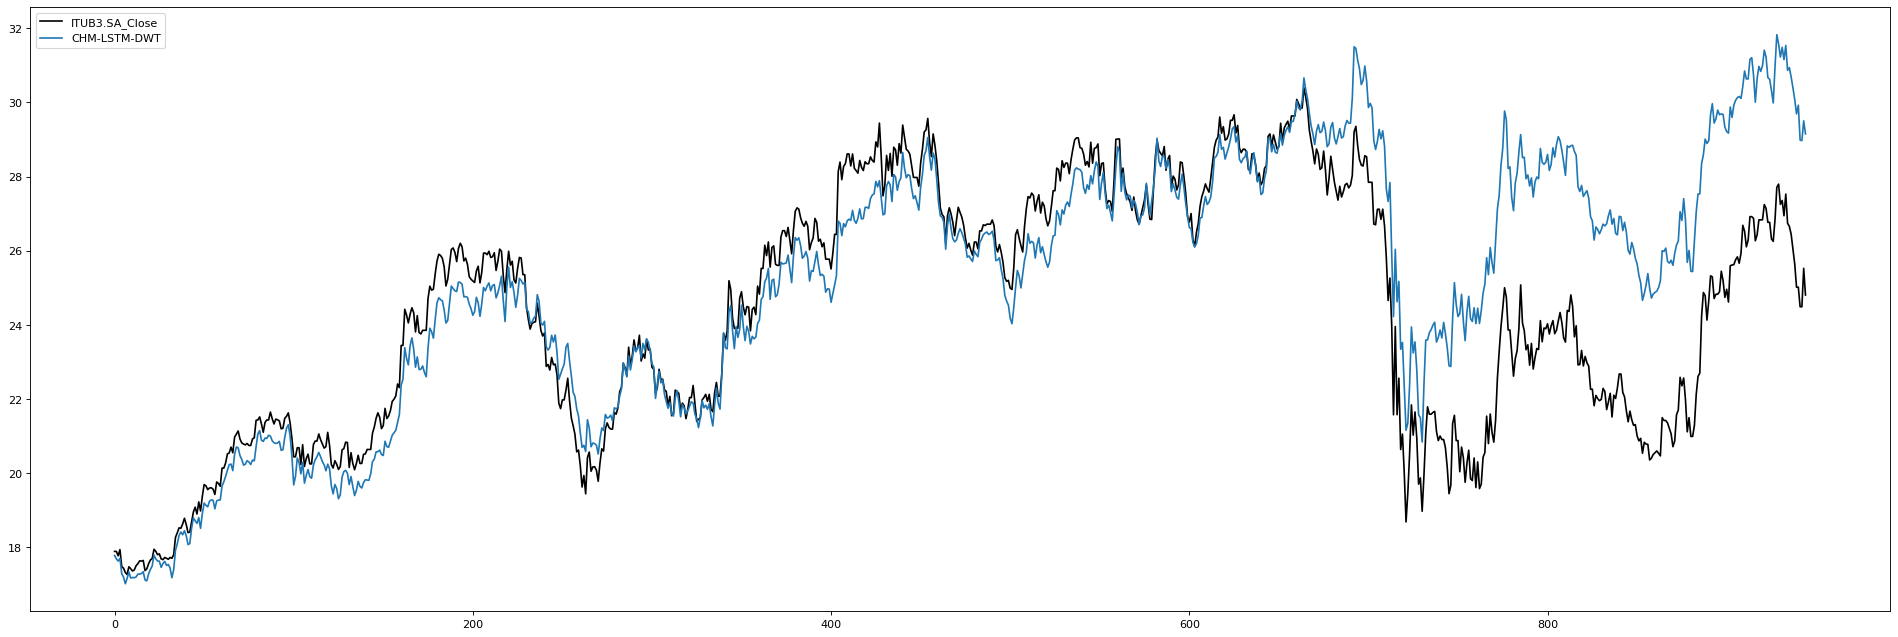

CHM-ESN-DWT


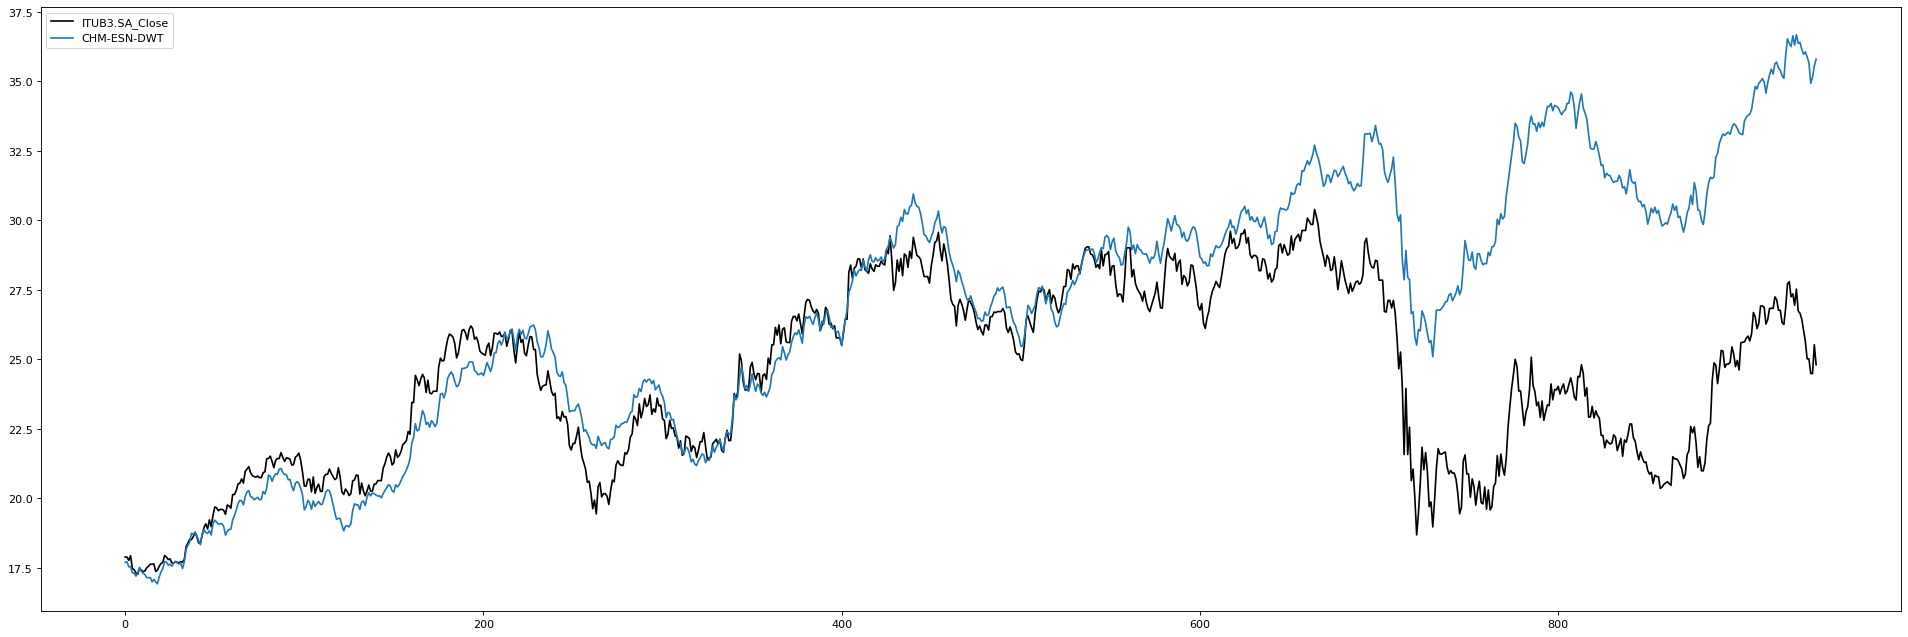

CHM-LSTM-EMD


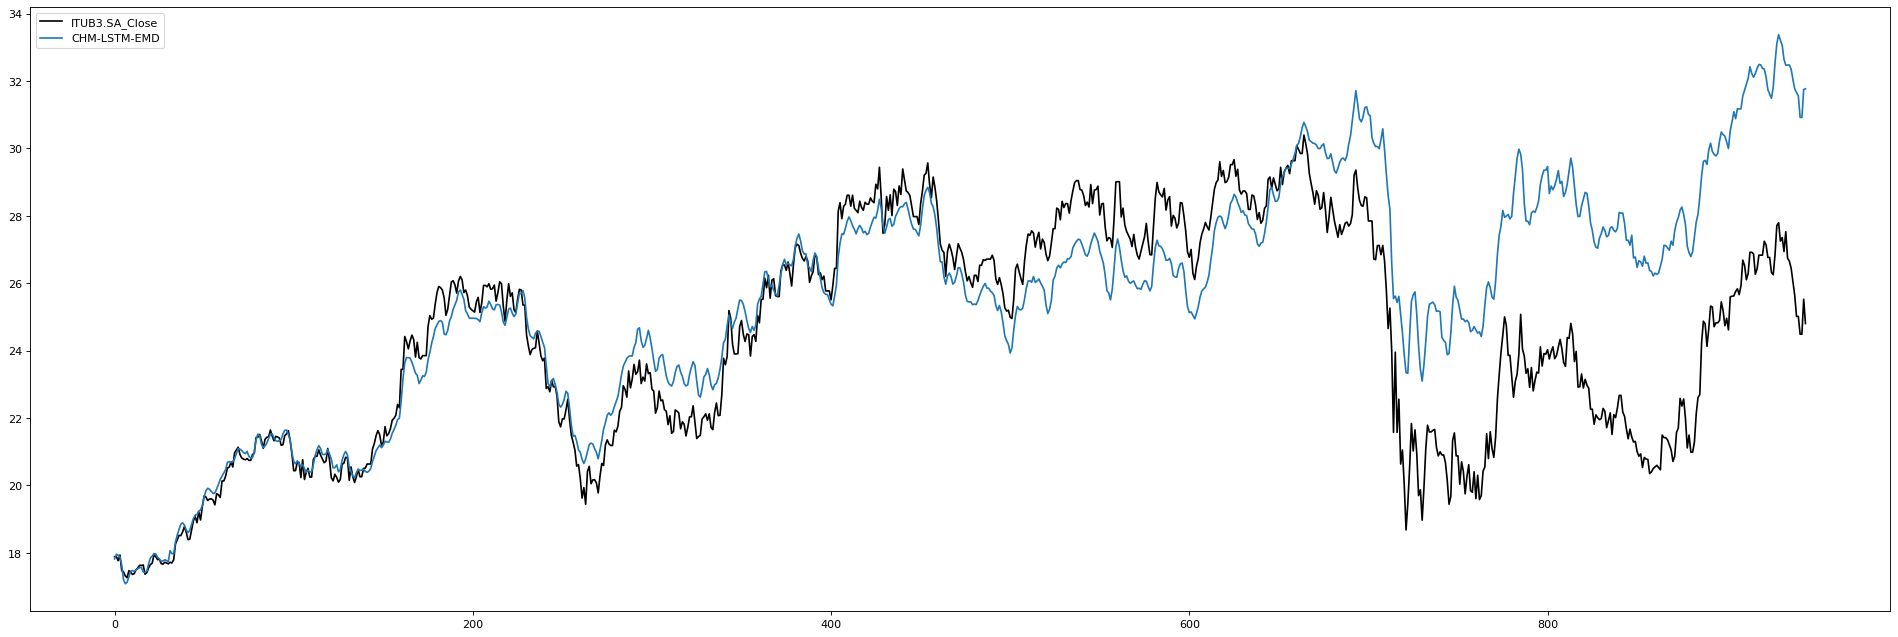

CHM-ESN-EMD


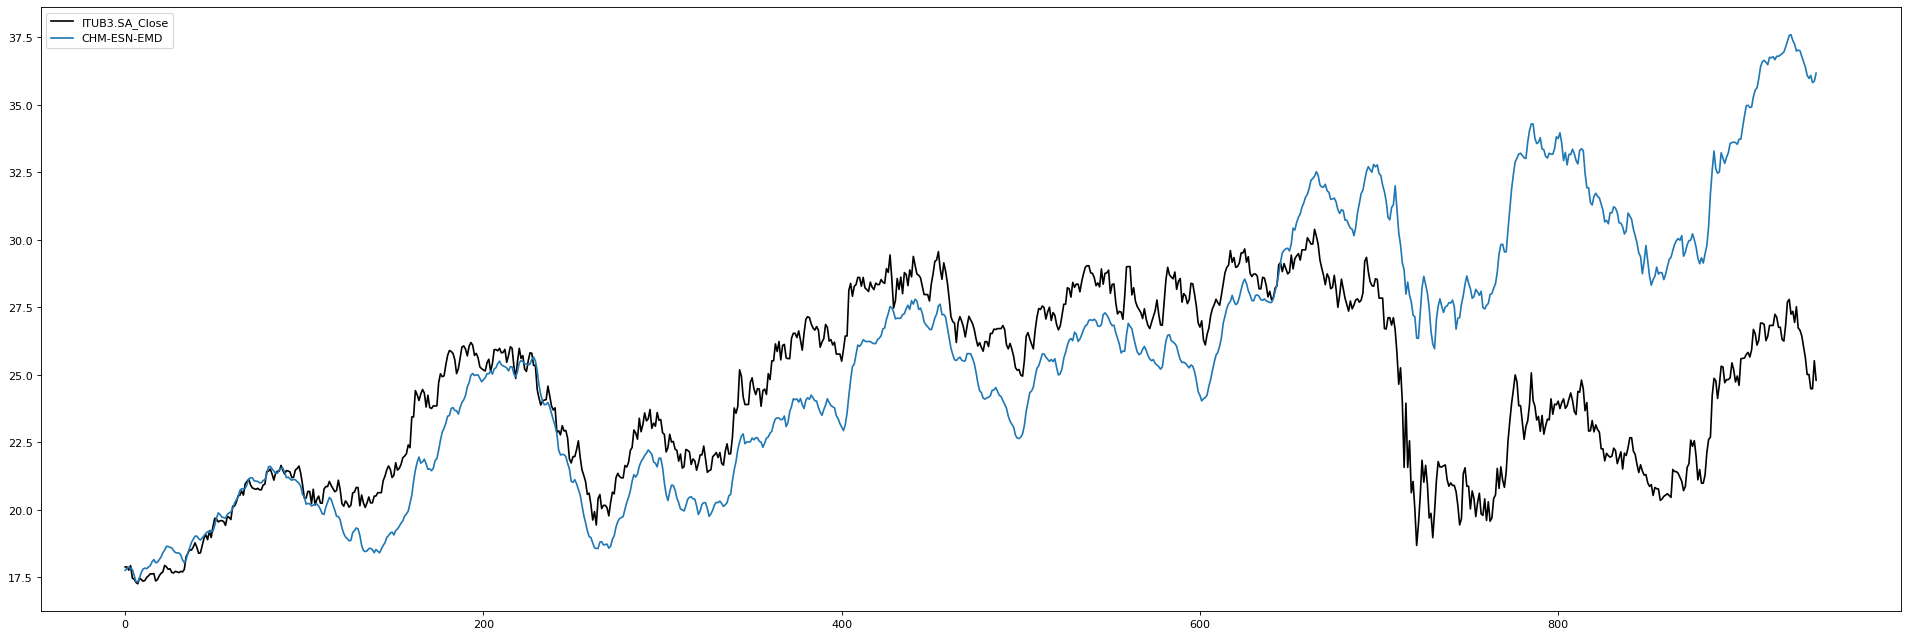

CHM-ESN-EMD-Freq


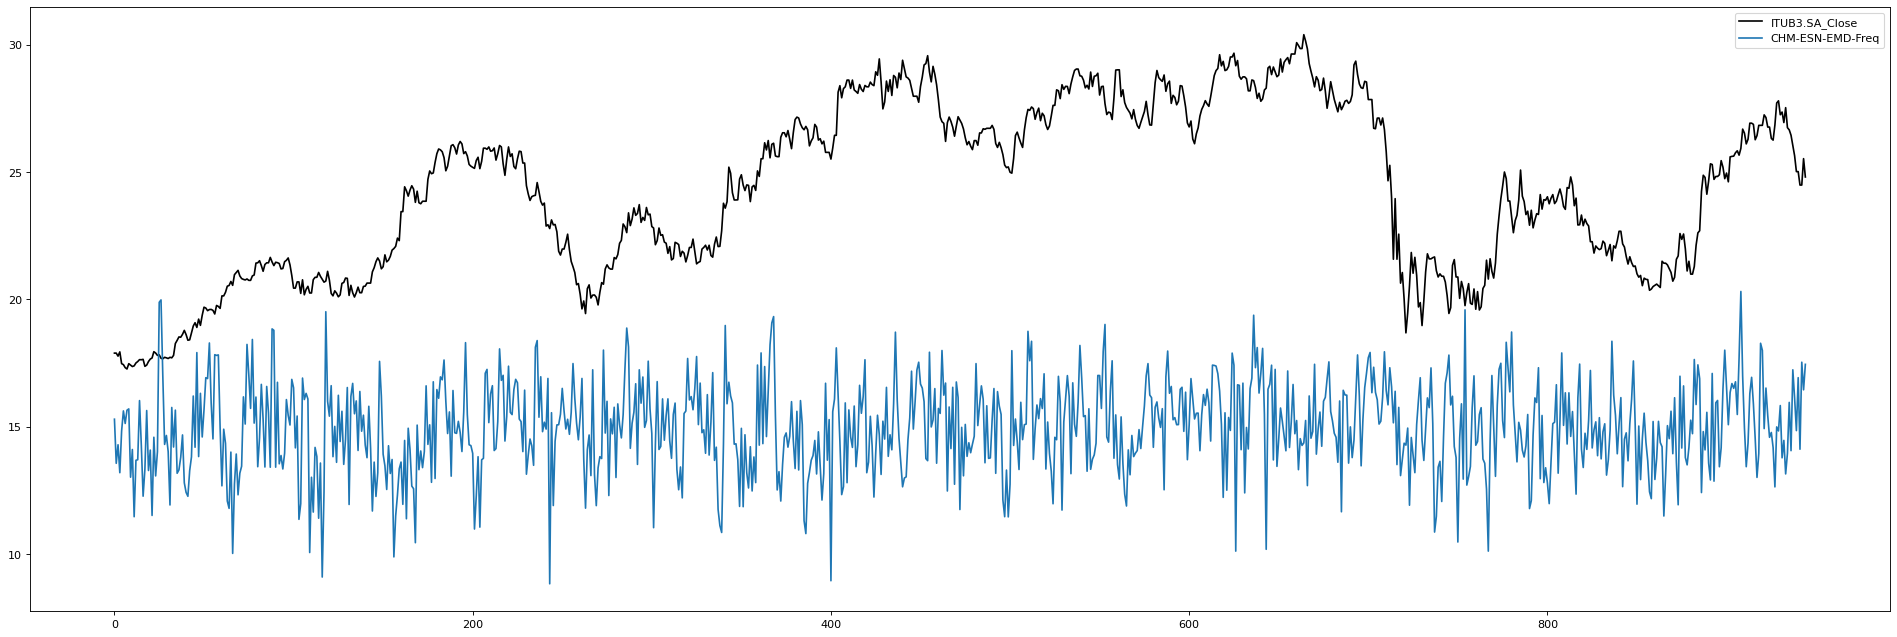

LSTM-DWT


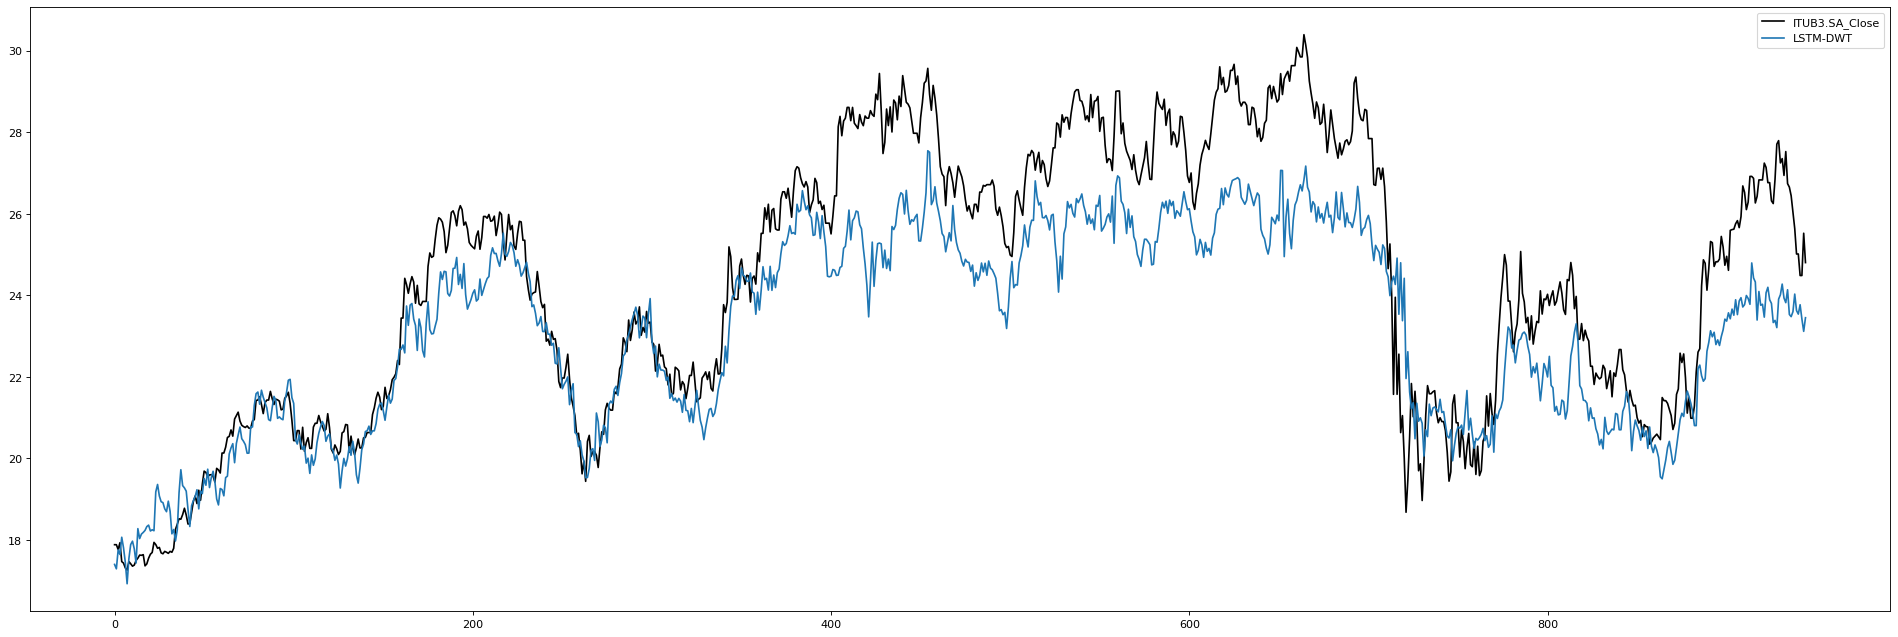

ESN-EMD-Freq


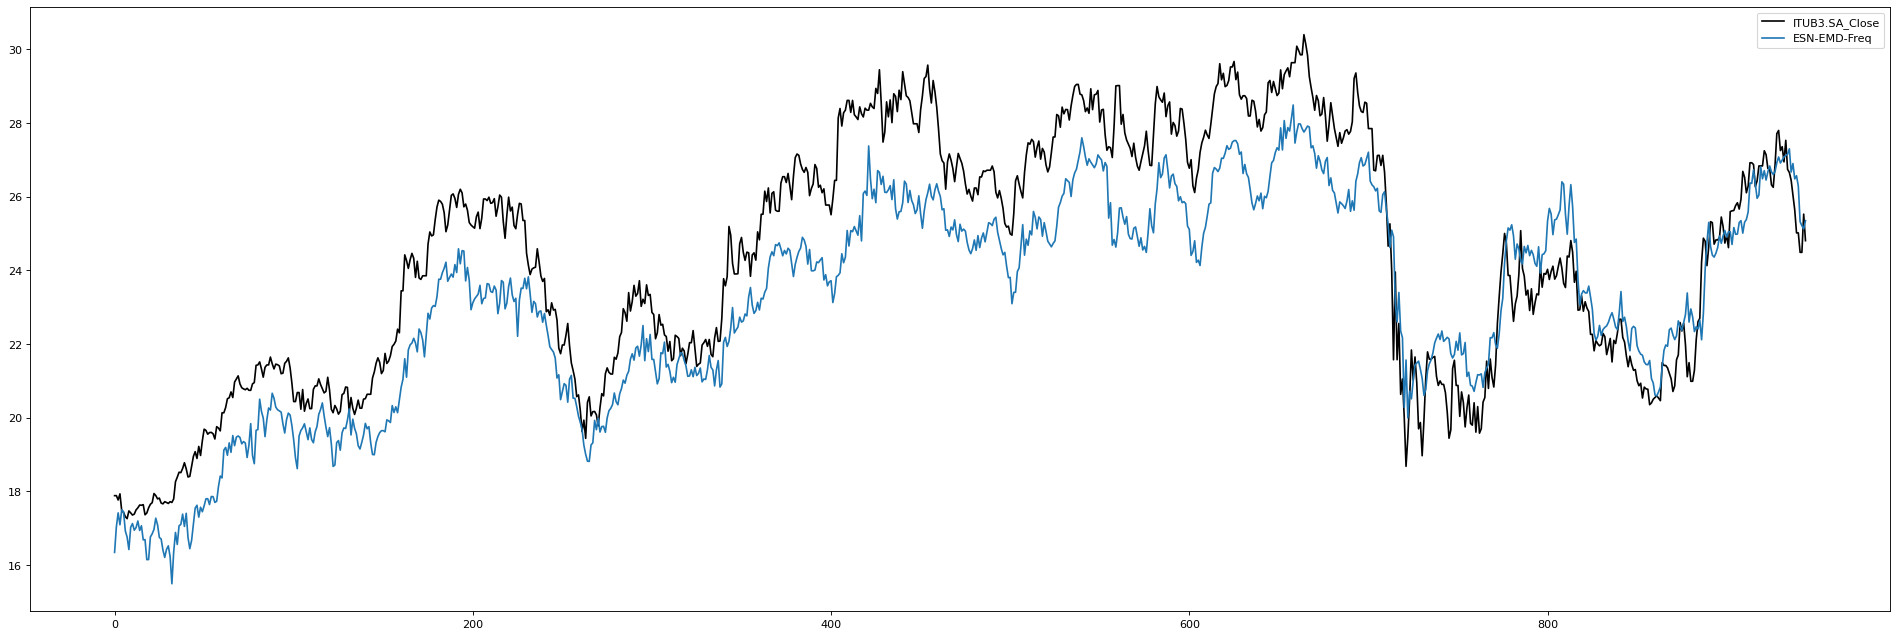

LSTM-EMD-Freq


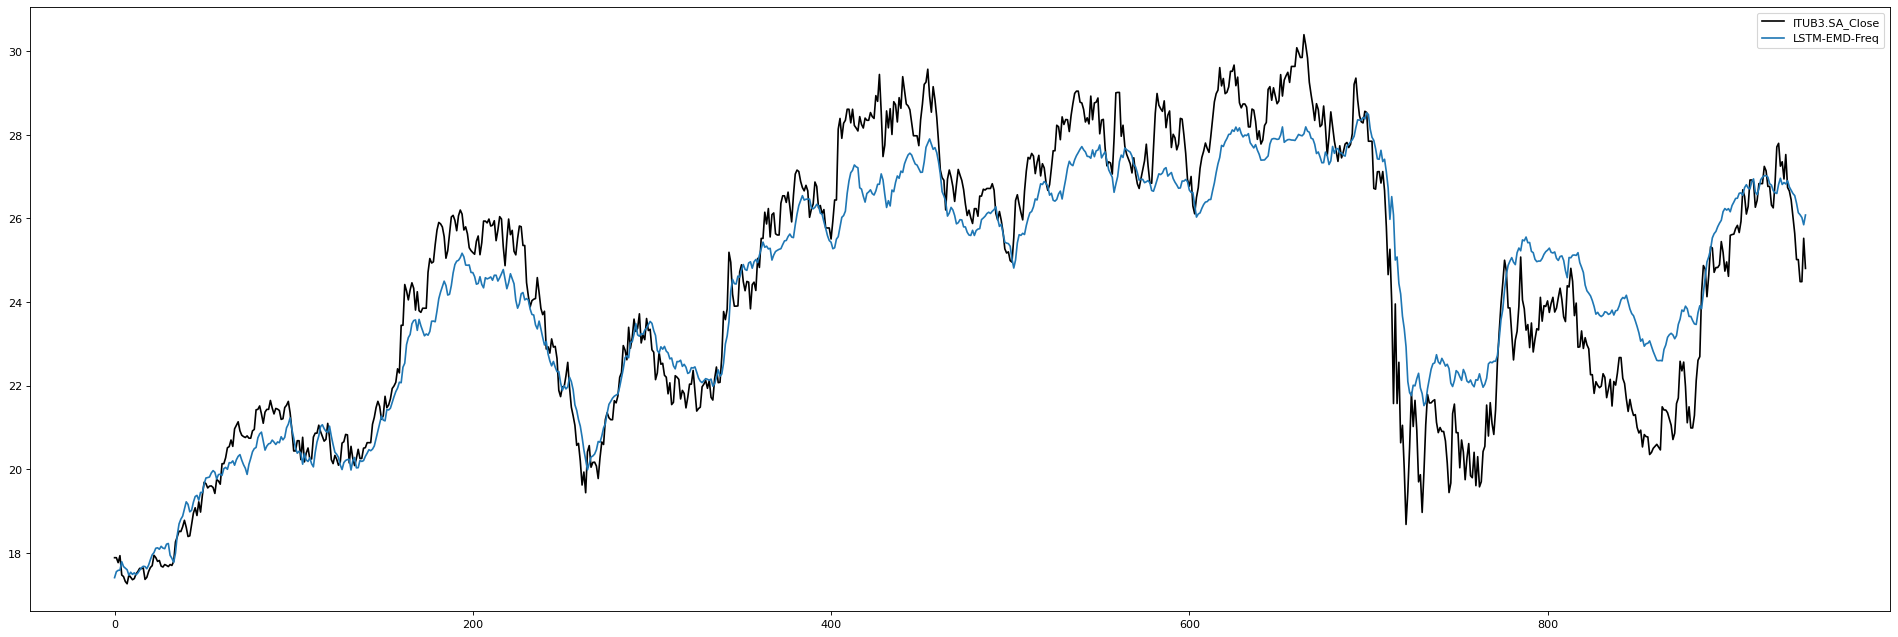

true


<Figure size 2400x800 with 0 Axes>

In [17]:
ground_truth = pp._scalers[y_cols].inverse_transform(test[7:][y_cols].values.reshape(-1,1))
ground_truth = ground_truth.ravel()
predicted_ds = pd.read_csv('../results/results_300.csv')
predicted_ds['true'] = ground_truth

for i in predicted_ds.columns:
    print(i)
    plt.figure(figsize=(30, 10), dpi=80)
    if i == "true":
        continue

    plt.plot(predicted_ds['true'], label='ITUB3.SA_Close', color='black')
    plt.plot(predicted_ds[i], label=i)
    plt.legend()
    plt.show()

#### Until X

In [34]:
print('CHM LSTM', mse(pred_lstm[:until], ground_truth[:until]))
print('CHM ESN', mse(pred[:until], ground_truth[:until]))
print('Normal LSTM', mse(res_pred_norm[:until], ground_truth[:until]))
print('Normal ESN', mse(res_pred_norm_esn[:until], ground_truth[:until]))

CHM LSTM 0.025216975015480005
CHM ESN 0.024977137473407702
Normal LSTM 0.07368472157499387
Normal ESN 0.9120593156086605


#### All Samples

In [35]:
print('CHM LSTM', mse(pred_lstm, ground_truth))
print('CHM ESN', mse(pred, ground_truth))
print('Normal LSTM', mse(res_pred_norm, ground_truth))
print('Normal ESN', mse(res_pred_norm_esn, ground_truth))

CHM LSTM 6.378097419701493
CHM ESN 4.378719831642072
Normal LSTM 3.018833856229354
Normal ESN 3.9020341406940076


# LSTM

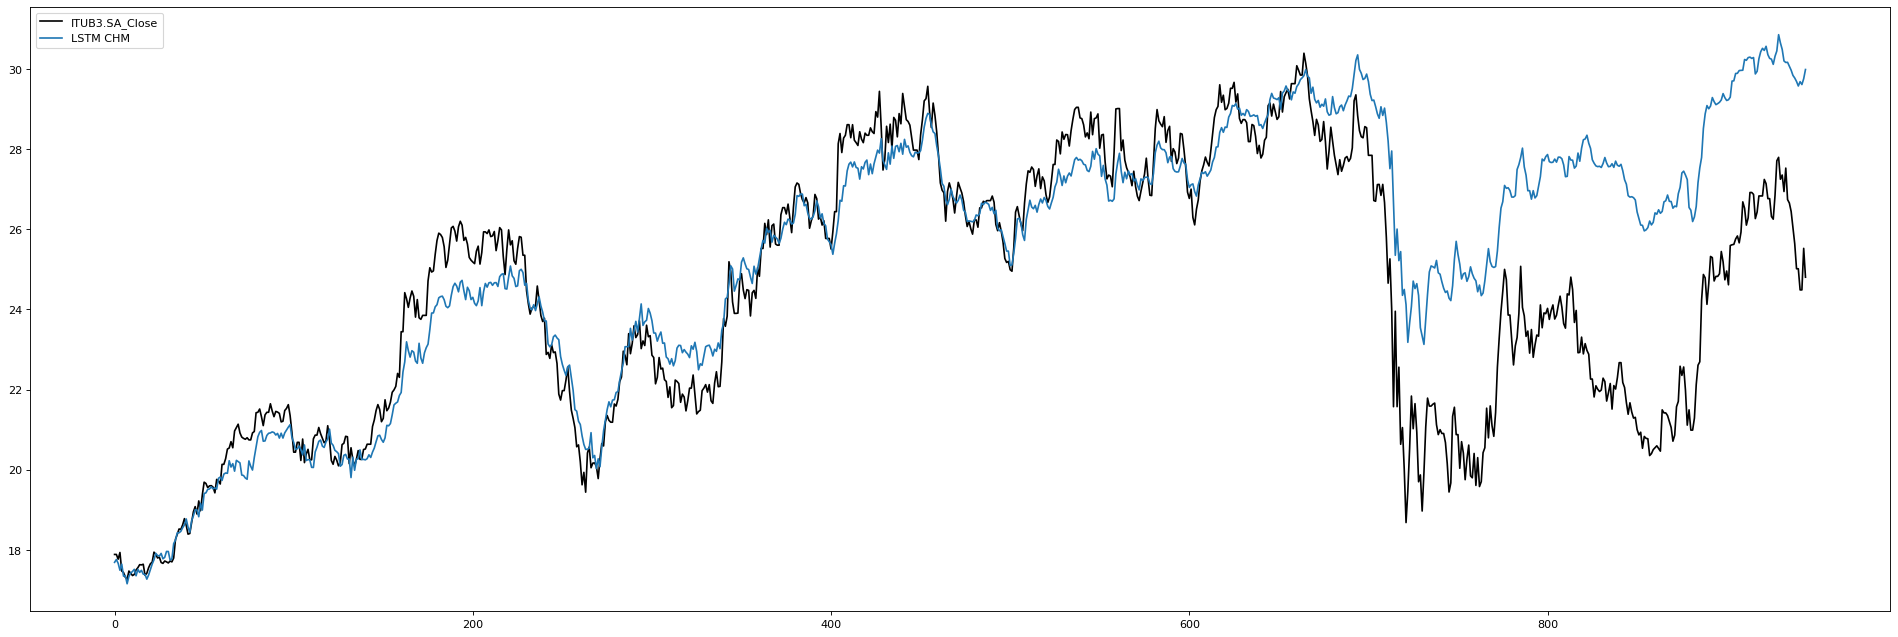

In [7]:
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(ground_truth, label='ITUB3.SA_Close', color='black')
plt.plot(pred_lstm, label='LSTM CHM')
plt.plot(res_pred_norm, label='LSTM')
#plt.plot(pred_norm_esn.predict_generator(test).ravel(), label='ESN')
plt.legend()
plt.show()


# ESN

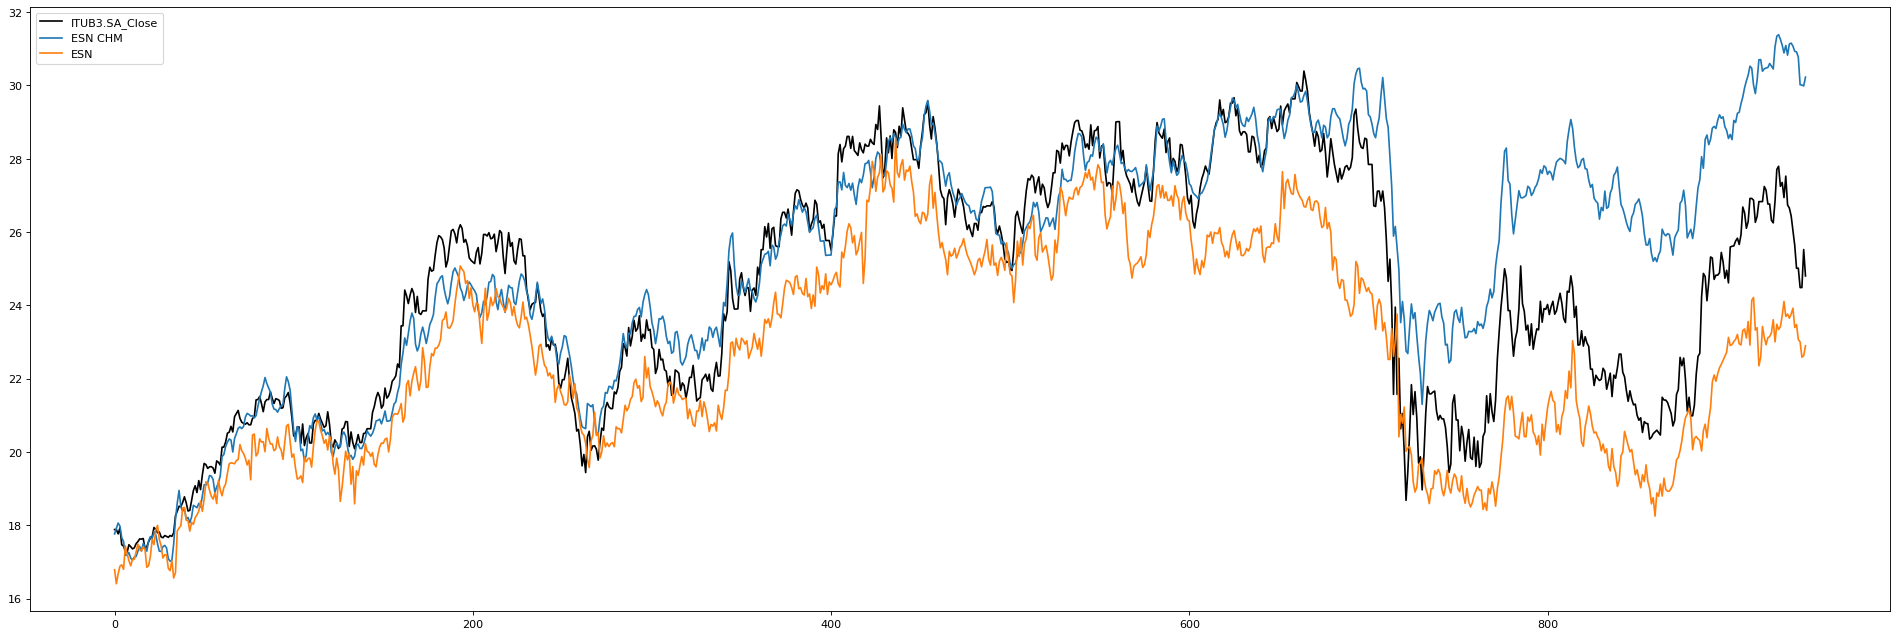

In [22]:
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(ground_truth, label='ITUB3.SA_Close', color='black')
plt.plot(pred, label='ESN CHM')
#plt.plot(pred_norm.predict_generator(test).ravel(), label='LSTM')
plt.plot(res_pred_norm_esn, label='ESN')
plt.legend()
plt.show()


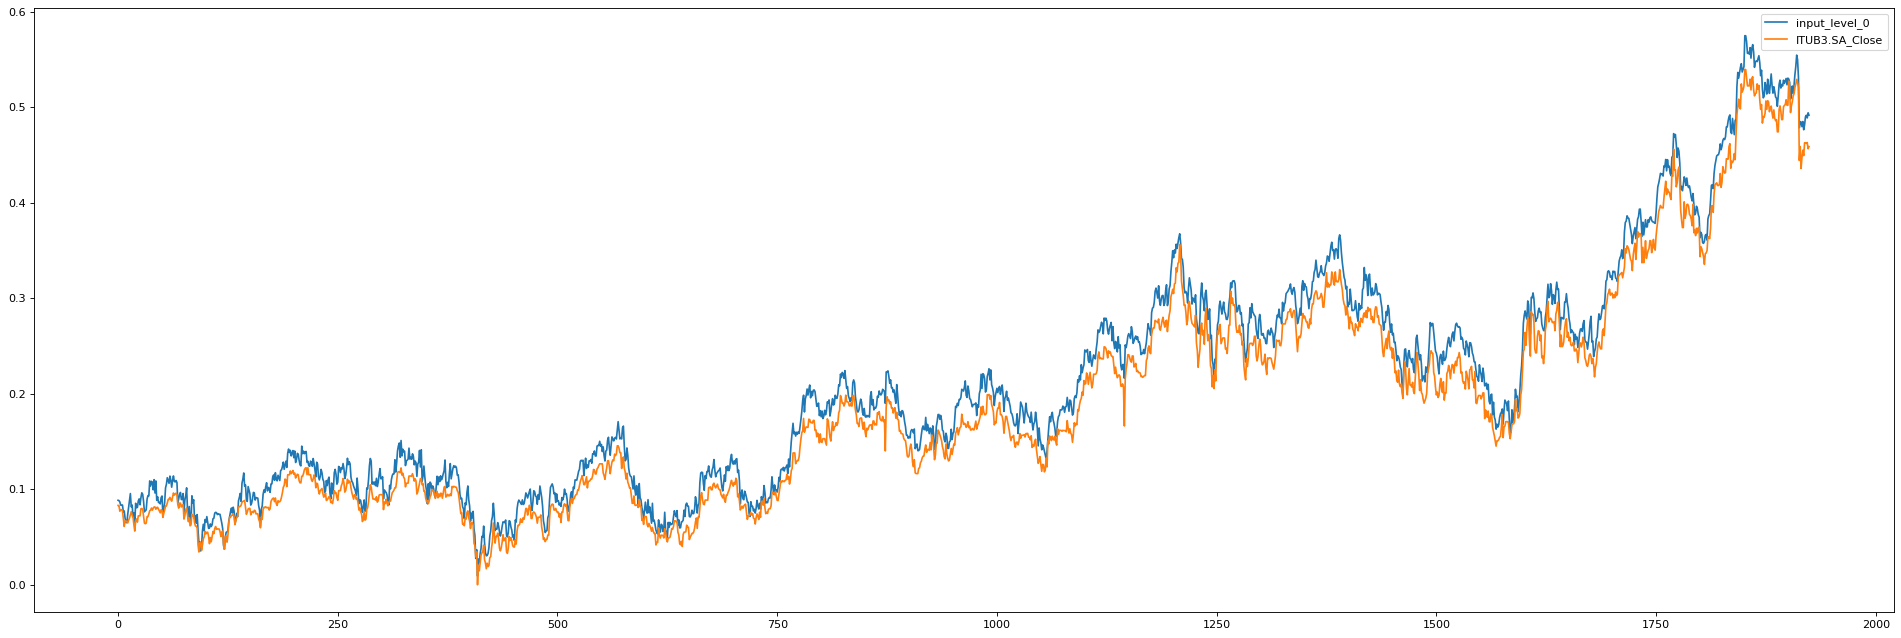

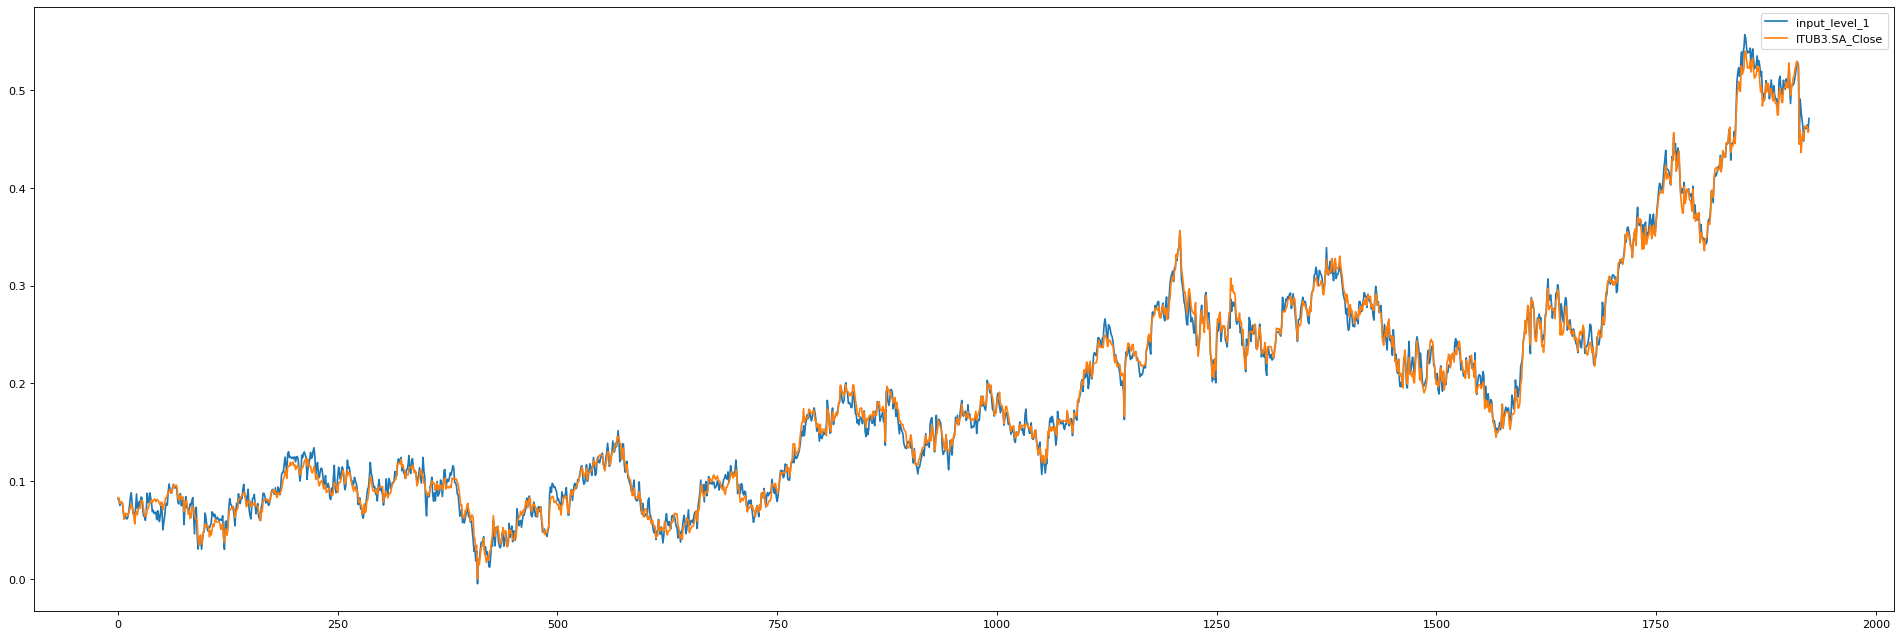

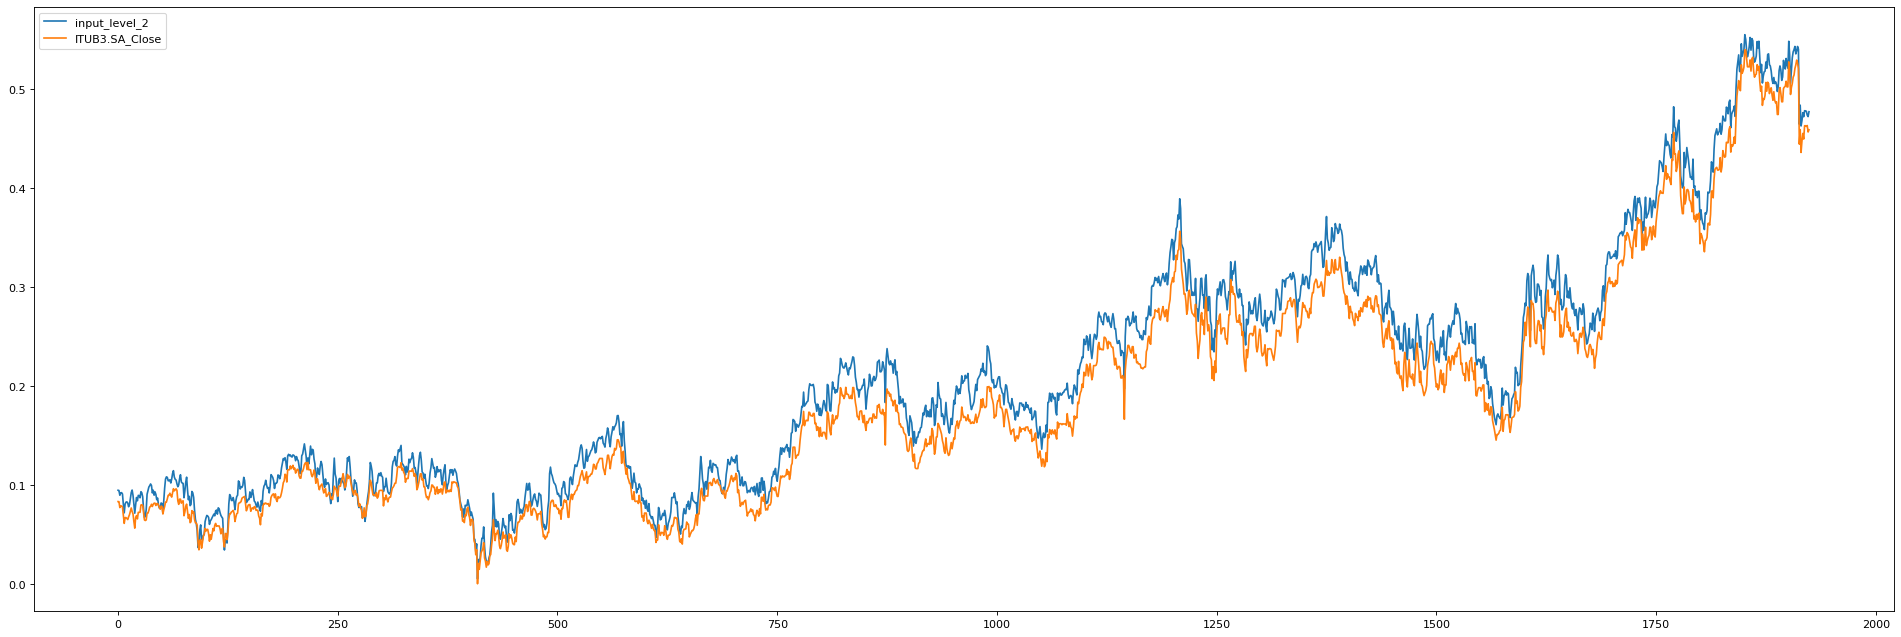

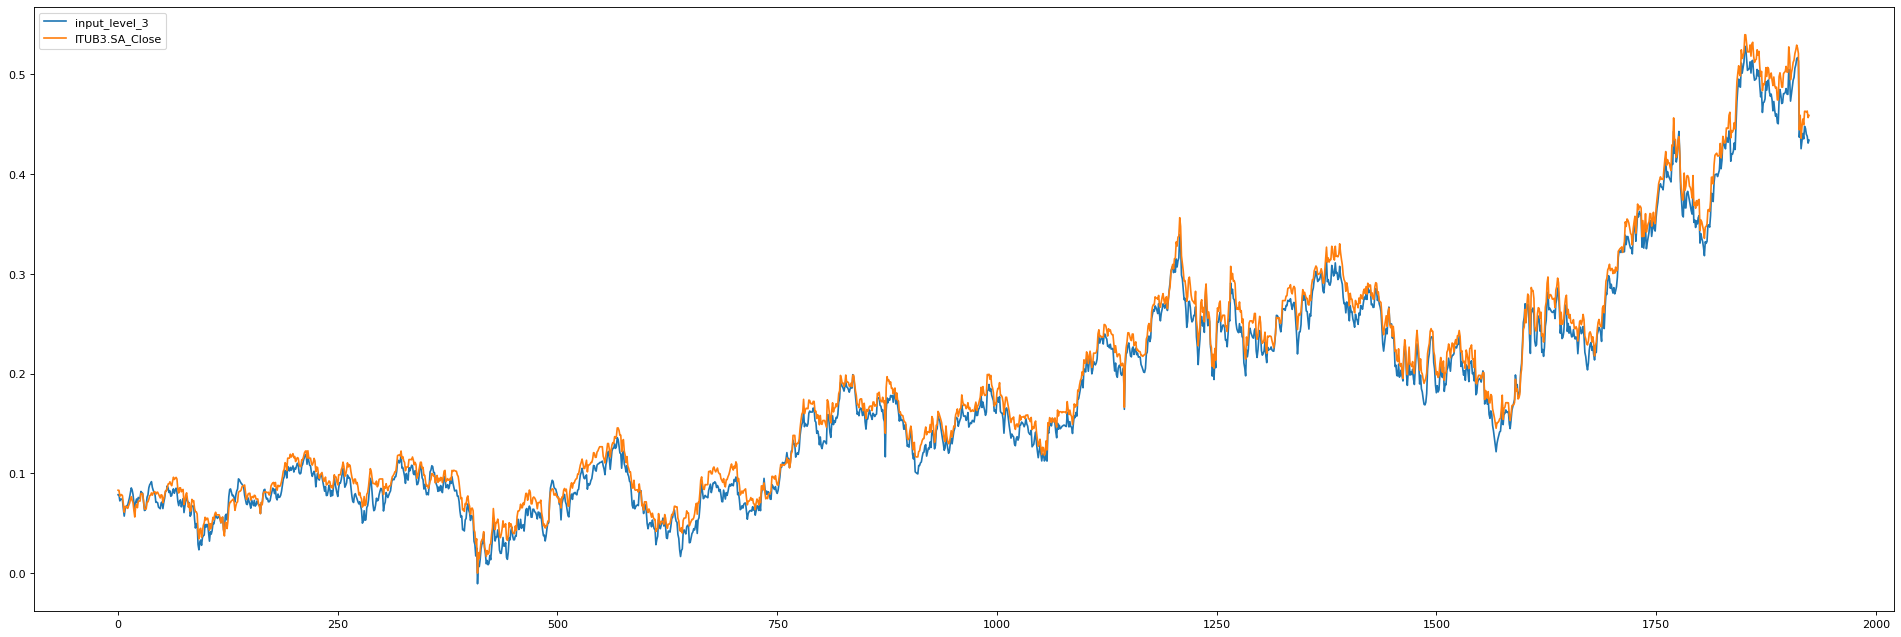

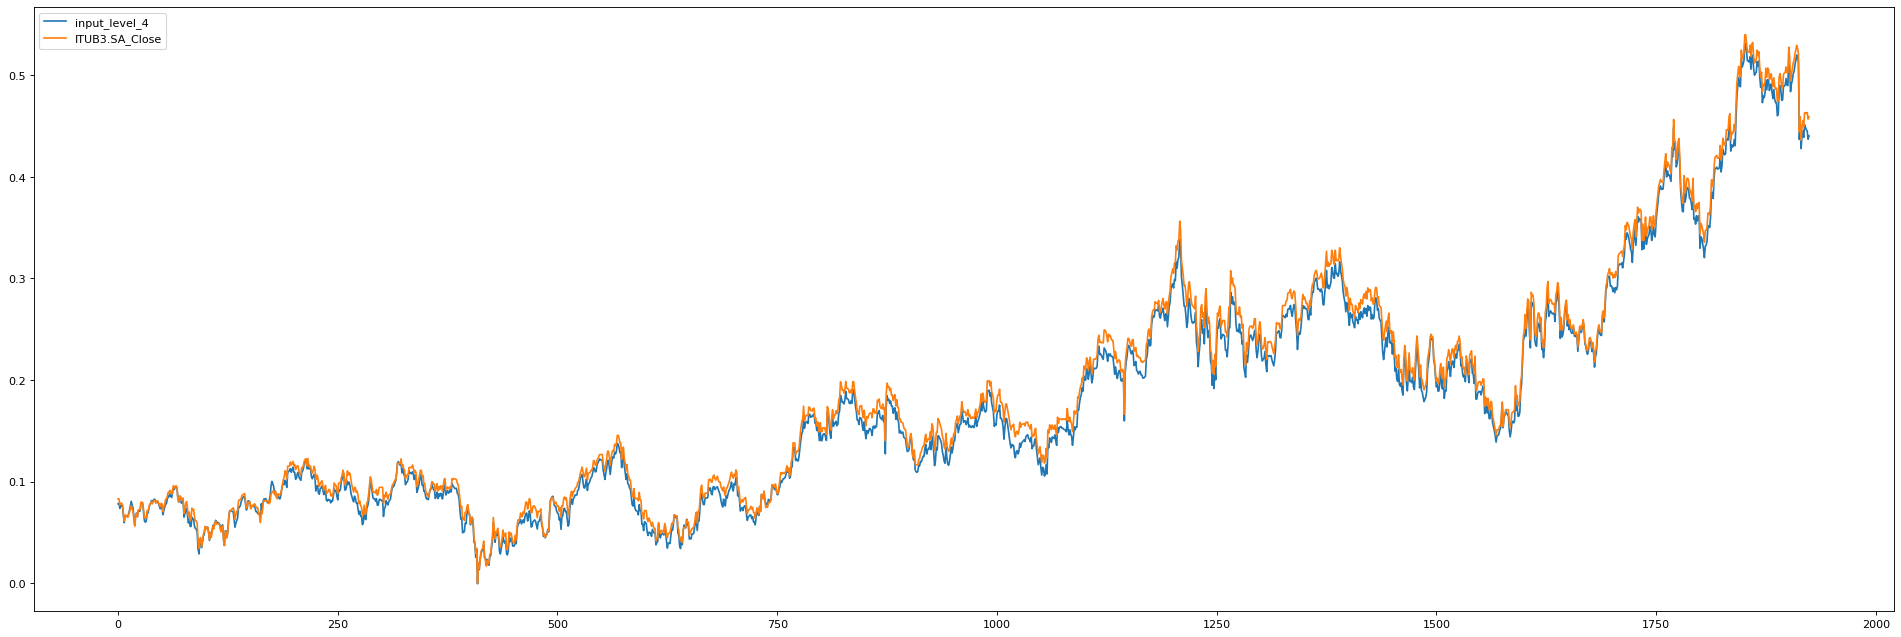

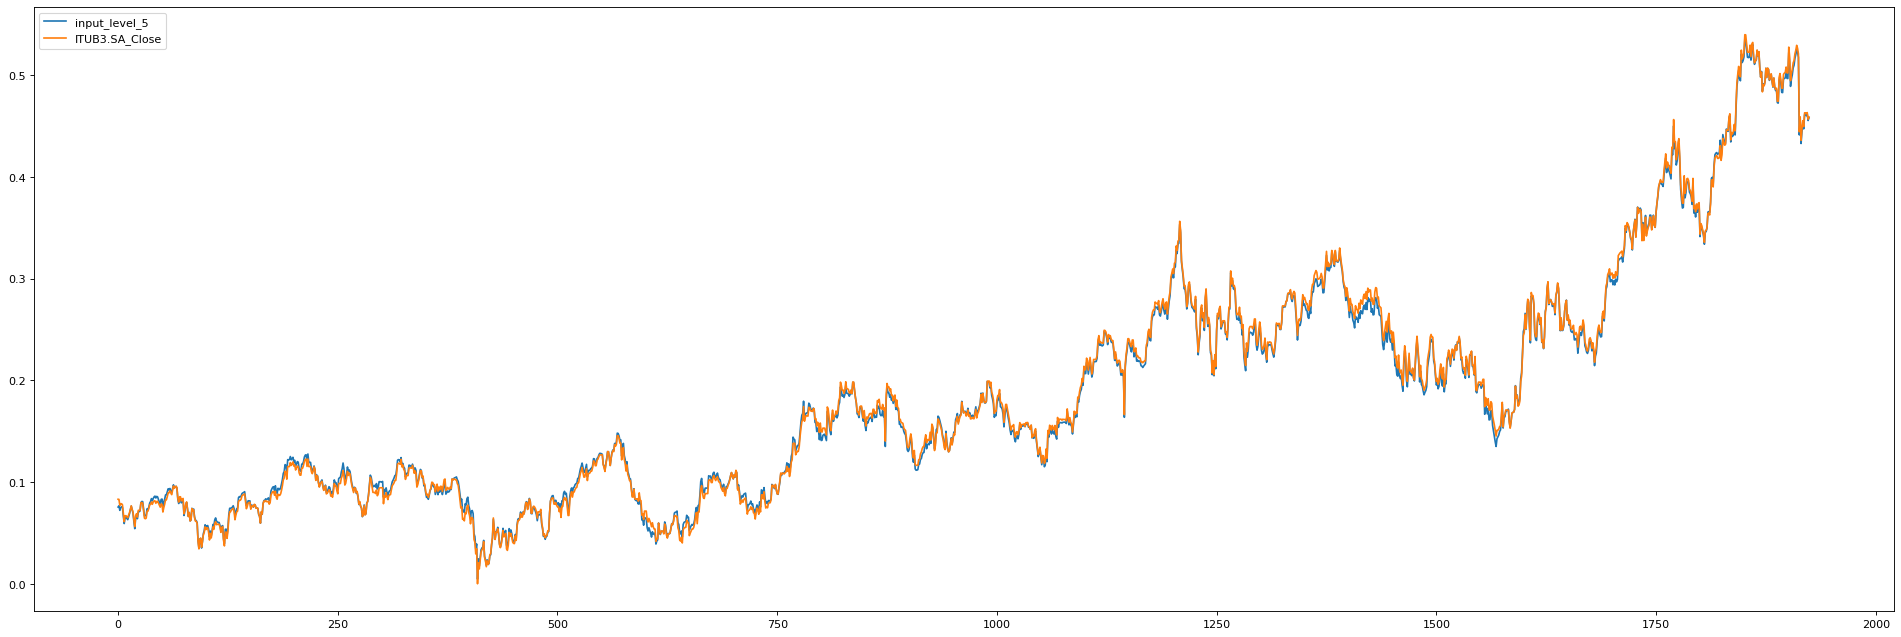

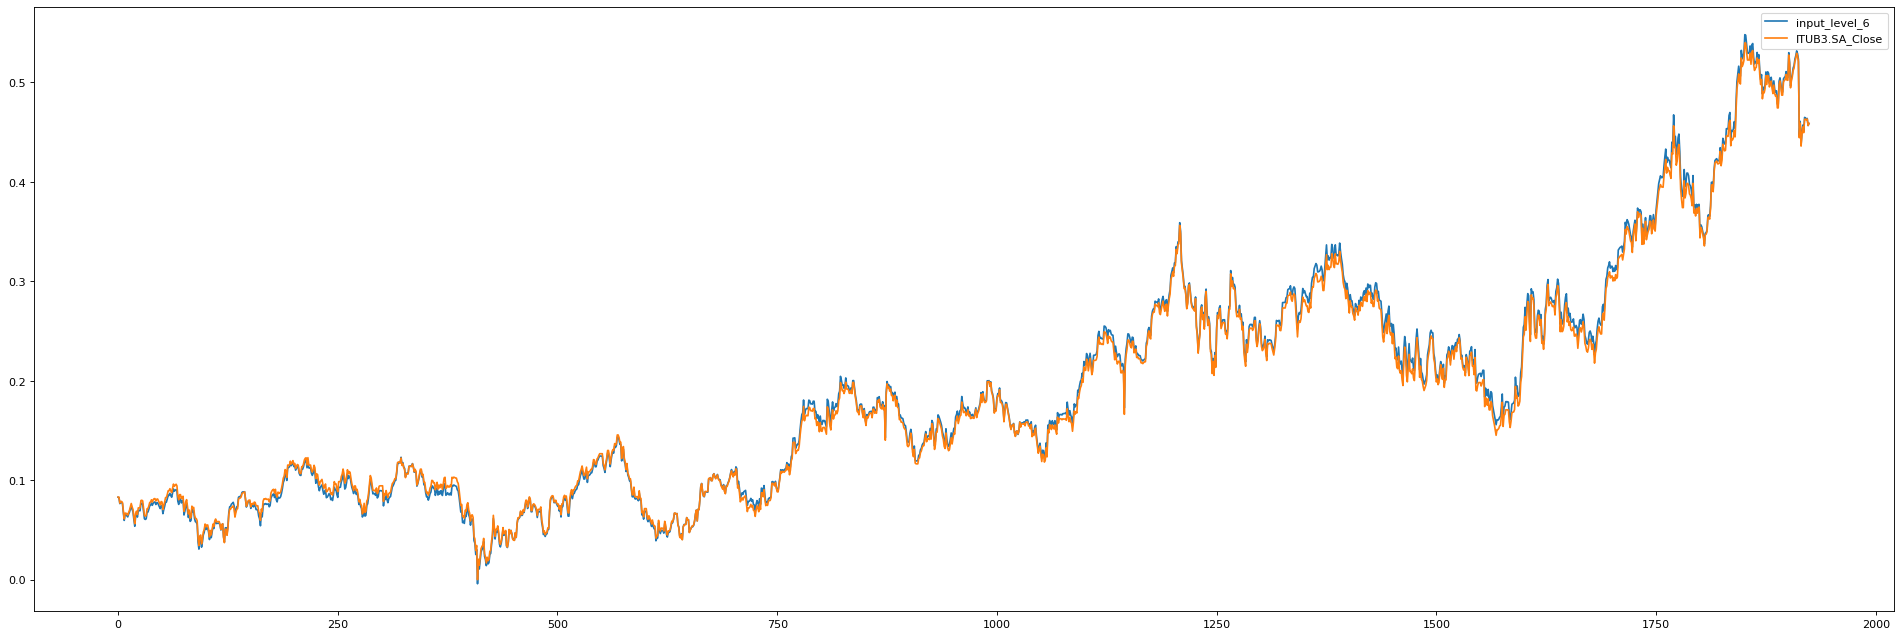

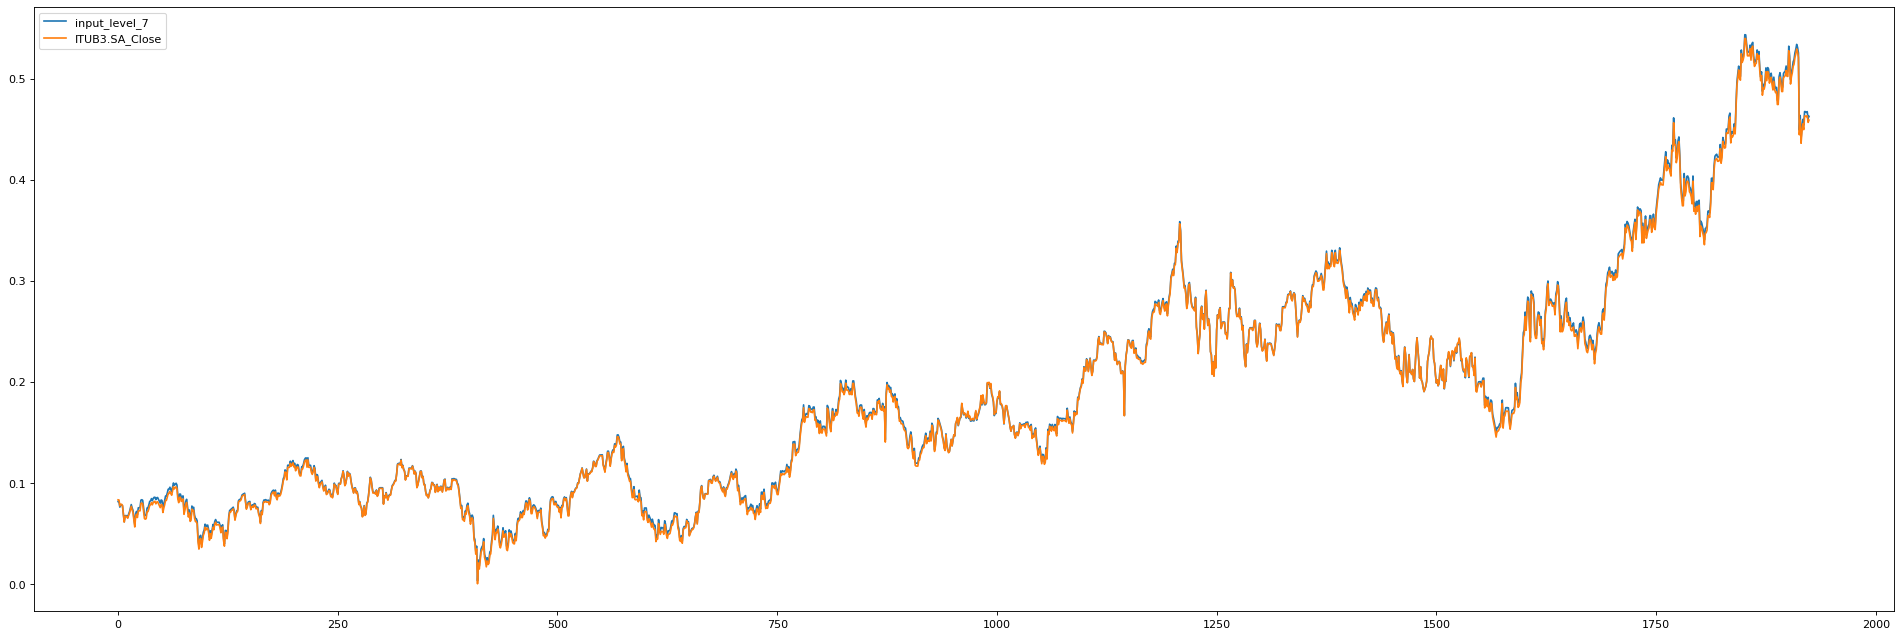

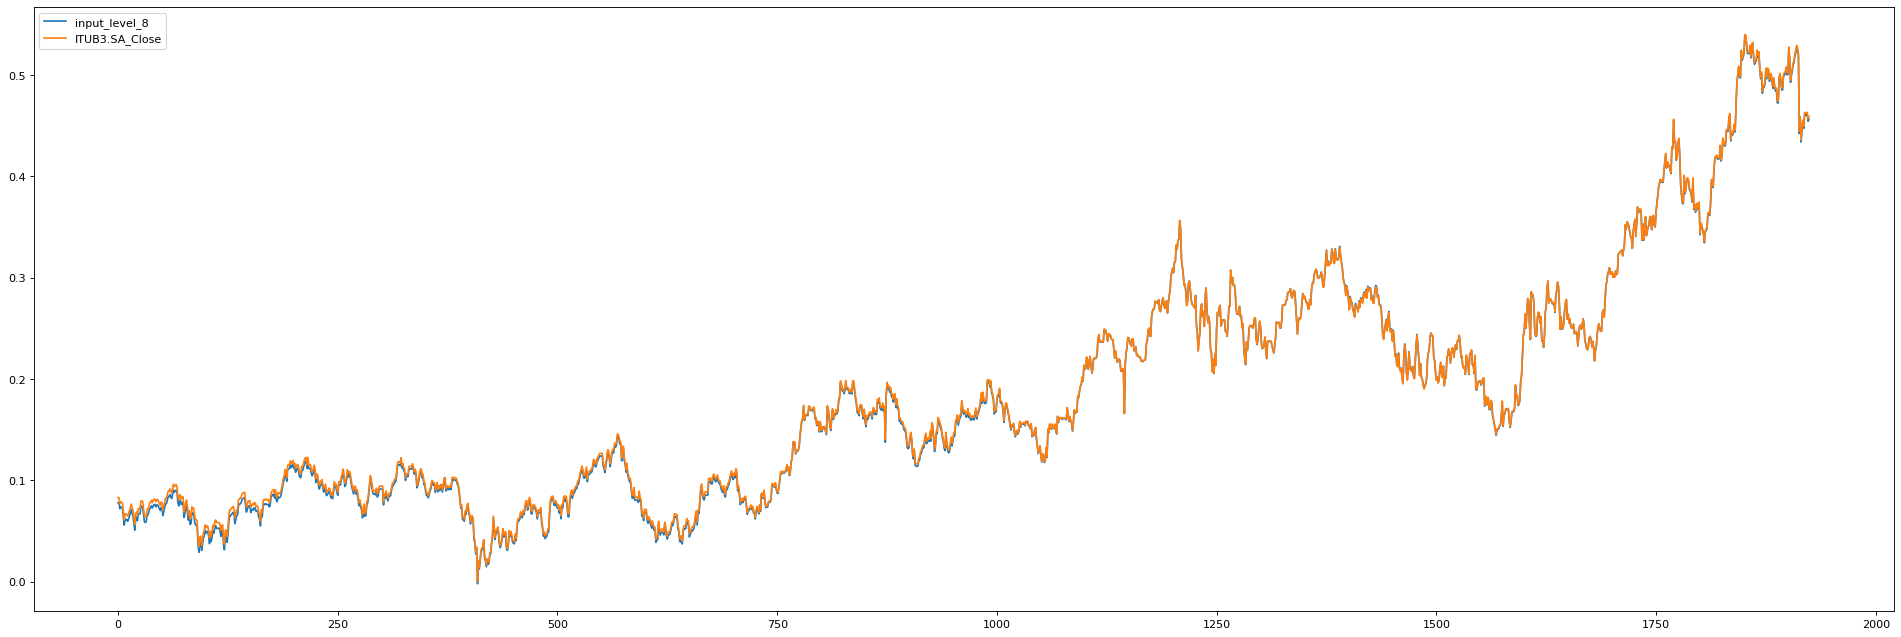

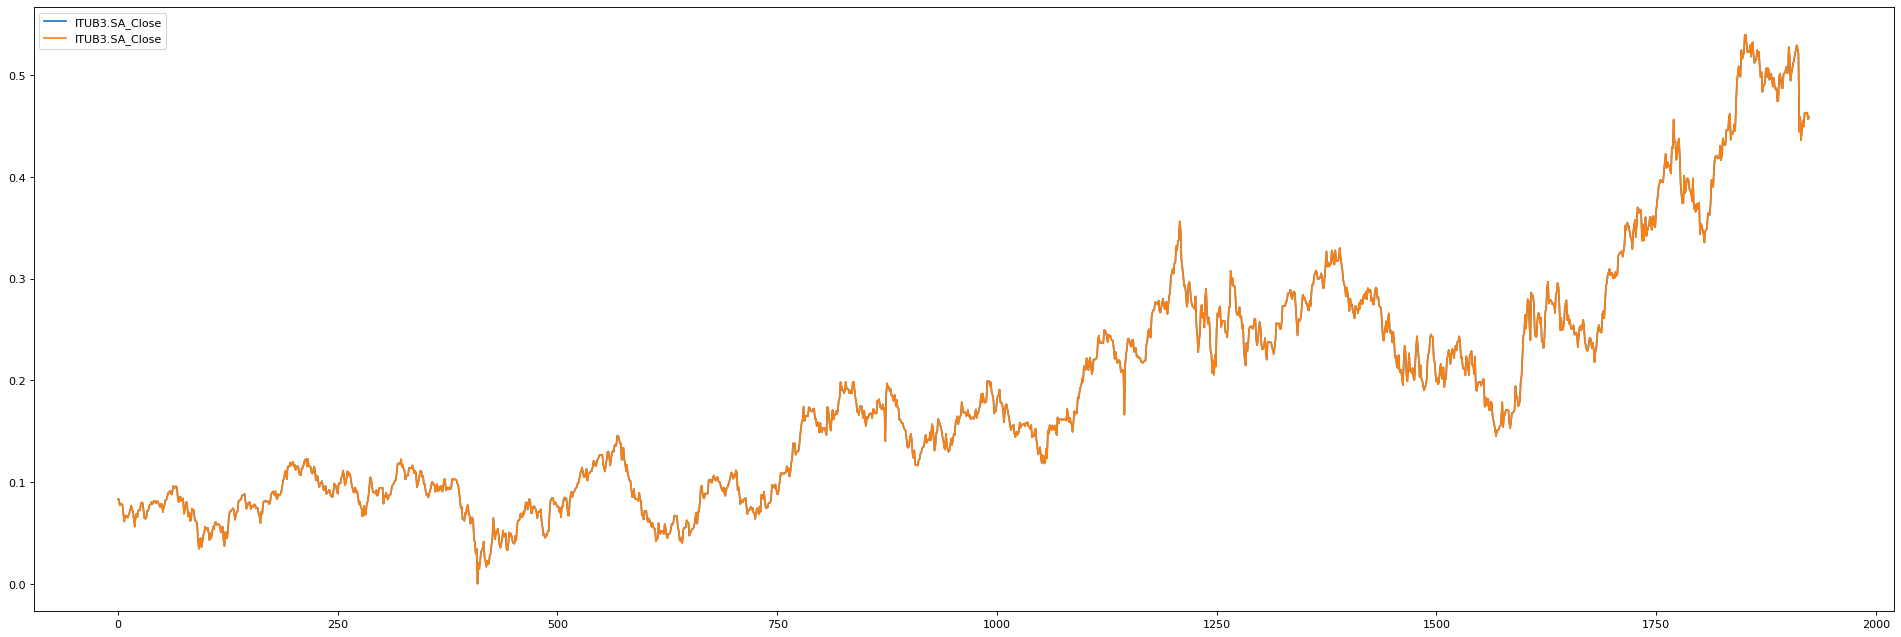

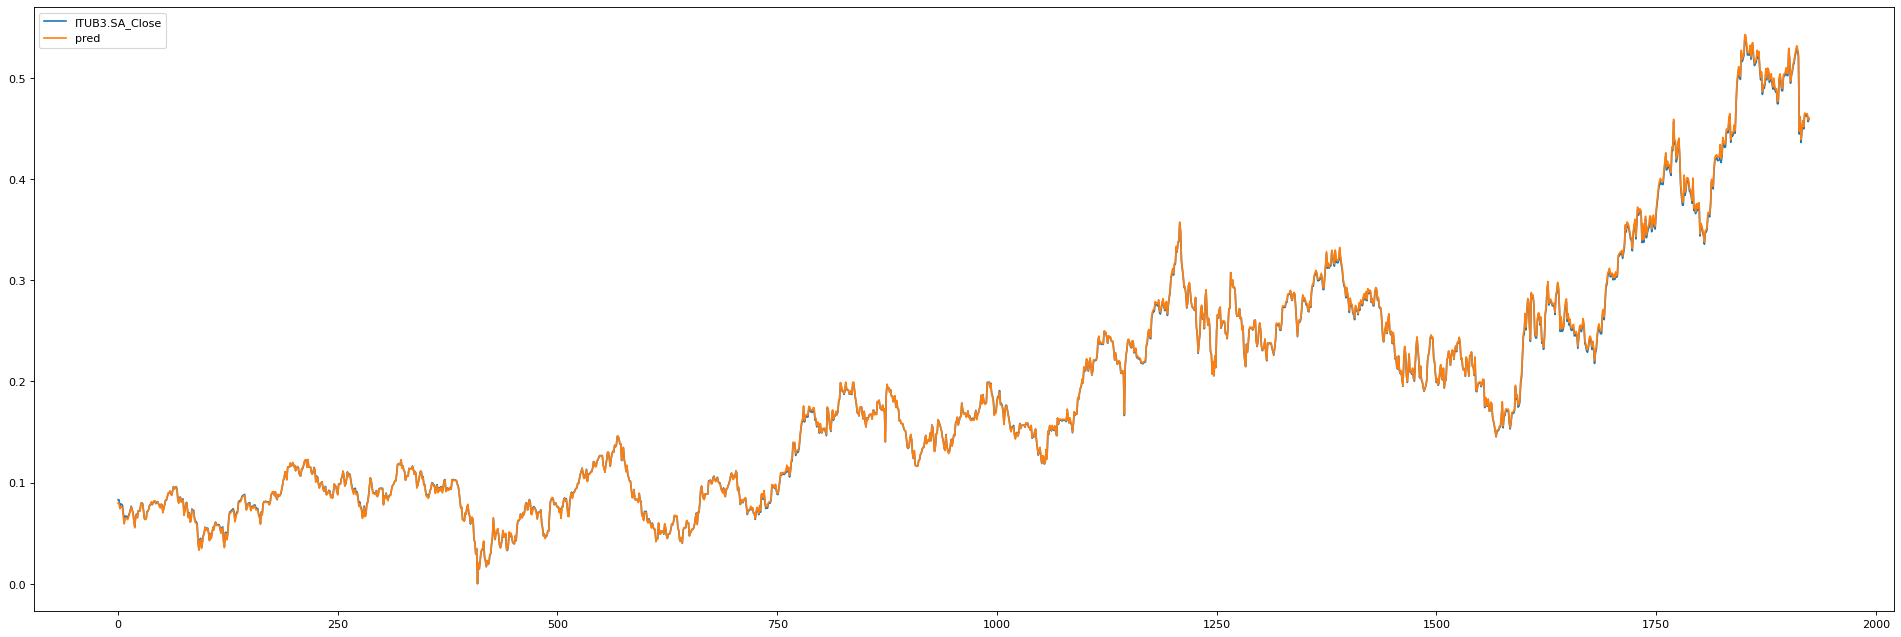

[0.12252654108718941, 0.049623126723233116, 0.12891477741274315, 0.09937456020940758, 0.061936766804643176, 0.02505006774722503, 0.030213825140100358, 0.016885336291968218, 0.022028340477002282]
Model :  0.006824138936448973
Average of Levels :  0.06183926021039026


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape

mape_list = list()

for i in chm._list_stages_bottom_up[0]._regressor.ds.columns:

    plt.figure(figsize=(30, 10), dpi=80)
    mape_list.append(mape(chm._list_stages_bottom_up[0]._regressor.ds[i],chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close']))
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds[i], label=i)
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')
    plt.legend()
    plt.show()

re = chm._list_stages_bottom_up[0]._regressor
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(re.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')

pred = re.predict(re.ds[re.x_cols])
plt.plot(pred, label='pred')

plt.legend()
plt.show()
mape_list.pop()
print(mape_list)
print('Model : ',mape(pred ,chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'][-len(pred):]))
print('Average of Levels : ',sum(mape_list)/len(mape_list))